In [1]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from time import strftime
%matplotlib inline

In [2]:
filedirec = r"D:\Files_Reutlingen_Jenny\main_191021extra"
inputdirectory = r"D:\Files_Reutlingen_Jenny\main_191021extra\191021_extra"
os.chdir(inputdirectory)

In [3]:
filelist = glob.glob('*.h5')
filelist

['aCSF_adult_15min_spont.h5',
 'hCSF_adult_20min_spont0002.h5',
 'hCSF_child_20min_spont.h5']

In [4]:
labeldic = np.load('labeldictionary_MCS_256MEA.npy', allow_pickle='TRUE').item()

In [5]:
filename=filelist[0]


In [6]:
filebase = filename.split('.')[0]

In [6]:
recording_MEA=se.MCSH5RecordingExtractor(os.path.join(inputdirectory, filename))
recording_f = st.preprocessing.bandpass_filter(recording_MEA, freq_min=150, freq_max=5000, filter_type='butter', order=2)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


In [7]:
recording_cmrprobe=recording_MEA.load_probe_file(probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb")

In [6]:
timestr = strftime("%d%m%Y")
outputdirectory = os.path.join(filedirec, '_output_Spikesorting_'+ timestr).replace('\\','/')

probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb"
outputdirectory_SC='D:/Files_Reutlingen_Jenny/main_191021extra/191021_extra_Spikesorting/output_Spykingcirucs'


In [7]:
outputdirectory

'D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_20042021'

In [8]:
outpath=os.path.join(outputdirectory+'_'+filename.split('.')[0]+'_spikesorting').replace("\\","/")
try:
    os.mkdir(outpath)
except OSError:
    print ("Creation of the directory %s failed" % outpath)
else:
    print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_20042021_aCSF_adult_15min_spont_spikesorting 


In [9]:
outpath_SC=os.path.join(outpath, 'output_spykingcircus').replace("\\","/")
try:
    os.mkdir(outpath_SC)
except OSError:
    print ("Creation of the directory %s failed" % outpath)
else:
    print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_20042021_aCSF_adult_15min_spont_spikesorting 


In [7]:
outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'

In [8]:
os.chdir(outpath)

In [13]:
# cutting out 2 minutes

fs = recording_cmrprobe.get_sampling_frequency()
fs = np.round(fs)
#recording_sub = se.SubRecordingExtractor(recording_cmrprobe, start_frame=200*fs, end_frame=320*fs)

NameError: name 'recording_cmrprobe' is not defined

In [22]:
# get the recording length, divide it into 120 second frames
recording_length = recording_cmrprobe.get_num_frames()
recording_seconds = recording_length/fs




In [9]:
def divide_recording_to_sub(recording, sublength_seconds):
    
    
    subrecording_dic = {}
    recording_length = recording.get_num_frames()
    recording_seconds = recording_length/fs
    end_frame = int(recording_seconds)
    
    for snippet in range(0, end_frame, sublength_seconds):
        sub_start = snippet
        sub_end = snippet + sublength_seconds
        if sub_end > end_frame:
            sub_end = end_frame
        sub_str = 'sec_'+str(sub_start)+'-'+str(sub_end)
    
        subrecording_dic[sub_str] = se.SubRecordingExtractor(
            recording_cmrprobe, start_frame = sub_start*fs,
            end_frame = sub_end*fs)
    
    return subrecording_dic
    
    

In [48]:
subrecording_dic

{'sec_0-200': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x28156a46040>,
 'sec_200-400': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x28156022370>,
 'sec_400-600': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x28156a5bb50>,
 'sec_600-800': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281567c4e50>,
 'sec_800-900': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281567c4b50>}

In [51]:
subrecords = divide_recording_to_sub(recording_cmrprobe, 300)

In [52]:
subrecords

{'sec_0-300': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281560b60d0>,
 'sec_300-600': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x2814e8d1be0>,
 'sec_600-900': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281560b6d60>}

In [10]:
# make a cache for every part in the dictionary

def create_cache_for_subrecordings(subrecording_dic, filebase, outpath):

    for key in subrecording_dic:
        sub_cache = se.CacheRecordingExtractor(
            subrecording_dic[key])
        filepath = os.path.join(
            outpath, filebase+str(key)+'_filtered_data.dat'
            ).replace('\\','/')
        sub_cache.move_to(filepath) 
        sub_cache.dump_to_dict()
        filepathpickle = os.path.join(
            outpath, filebase+str(key)+'_recording.pkl'
            ).replace('\\','/')
        sub_cache.dump_to_pickle(filepathpickle)
        
    return 'Finished dumping the subrecords. To load, use the load_dumped_recordings function'
    

In [74]:
create_cache_for_subrecordings(subrecording_dic=subrecords, filebase=filebase, outpath=outpath)

'Finished dumping the subrecords. To load, use the load_dumped_recordings function'

In [11]:
def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    

In [12]:
loaded = load_dumped_subrecordings(outpath, filebase)

In [13]:
loaded

{'sec_0-300': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1df284dc430>,
 'sec_300-600': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1df284dc910>,
 'sec_600-900': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1df284c8b50>}

In [24]:

print(f'Cached channels: {recording_cache.get_channel_ids()}')
print(f'Cached channels ids: {recording_cache.get_channel_ids()}')
print(f'Channel groups after caching: {recording_cache.get_channel_groups()}')

Cached channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [20]:
# to load:
#recording_loaded = se.load_extractor_from_pickle('recording.pkl')
#recording_cache=recording_loaded

In [14]:
# loop to run spikesorter over different subrecordings
def run_spykingcircus_on_sub(subrecording_dic, directory):
    

    sorted_dic={}
    for key in loaded:
        outpath_SC=os.path.join(outpath, 'sorted_'+str(key)).replace('\\', '/')
        '''
        try:
            os.mkdir(outpath_SC)
        except OSError:
            print ("Creation of the directory %s failed" % outpath)
        else:
            print ("Successfully created the directory %s " % outpath)
        '''
        sorted_dic[key]=ss.run_spykingcircus(
            loaded[key], output_folder=outpath_SC)

    return sorted_dic
    

In [104]:
sorted_dic = run_spykingcircus_on_sub(loaded, outpath)

Creation of the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting failed
RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting\sorted_sec_0-300\run_spykingcircus.bat
Creation of the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting failed
RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting\sorted_sec_300-600\run_spykingcircus.bat
Creation of the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting failed
RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting\sorted_sec_600-900\run_spykingcircus.bat


In [105]:
sorted_dic

{'sec_0-300': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x2815658a040>,
 'sec_300-600': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x281563a3370>,
 'sec_600-900': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x28155ffcfd0>}

In [15]:
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic

In [16]:
sorted_dic = load_dumped_sorted_dic(outpath)

In [17]:
sorted_dic


{'sec_0-300': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1df284e31c0>,
 'sec_300-600': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1df284e3070>,
 'sec_600-900': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1df2ff7d5b0>}

In [18]:
waveforms = st.postprocessing.get_unit_waveforms(
    loaded['sec_0-300'], sorted_dic['sec_0-300'], memmap = True
    )

In [20]:
u = 'sec_0-300'

In [21]:
layerdic = {'layer1':[], 
            'layer2-3':['L01', 'M01', 'M02', 'M03', 'M15', 'M16', 'N01', 'N02', 'N03', 'N04', 'N05', 'N06', 'N07',
                        'N08', 'N09', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O01', 'O02', 'O03', 'O04', 
                        'O05', 'O06', 'O07', 'O08', 'O09', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'P01', 
                        'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 
                        'P15', 'P16', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15'],
           'layer4':['K01', 'K02', 'K14', 'K15', 'K16', 'L02', 'L03', 'L04', 'L05', 'L06', 'L07', 'L08', 'L09', 'L10', 'L11', 'L12', 
                     'L13', 'L14', 'L15', 'L16', 'M04', 'M05', 'M06', 'M07', 'M08', 'M09', 'M10', 'M11', 'M12', 'M13', 'M14'],
           'layer5-6':['K03', 'K04', 'K05', 'K06', 'K07', 'K08', 'K09', 'K10', 'K11', 'K12', 'K13', 'I01', 'I02', 'I03', 'I04', 
                       'I05', 'I06', 'I07', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'H01', 'H02', 'H03', 
                       'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                       'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11'],
           'whitematter':['D12', 'D13', 'D14', 'D15', 'D16', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]}

In [36]:
#load
#sorting_SC = se.SpykingCircusSortingExtractor(outpath_SC)


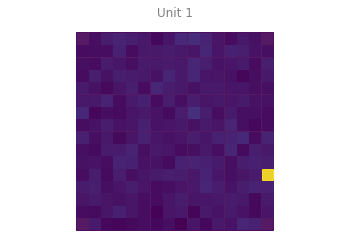

In [22]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[1])

{}


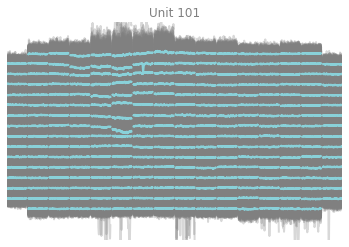

In [23]:
w_wf = sw.plot_unit_waveforms(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[101], color='#89D1D9')

<IPython.core.display.Javascript object>


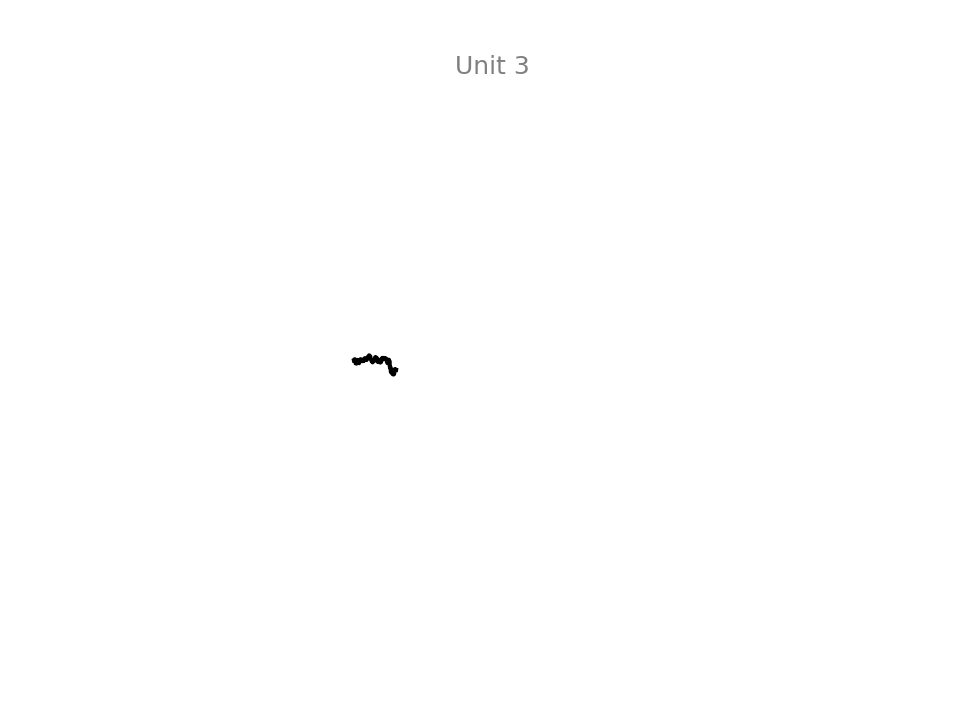

{}


In [132]:
sw.plot_unit_templates(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[3], max_channels=1, )

In [283]:
amplitudes = st.postprocessing.get_unit_amplitudes(loaded['sec_0-300'], sorted_dic['sec_0-300'])

In [293]:
np.mean(amplitudes[2])

5.267176434782609e-05

In [25]:
def units_to_pandas_DataFram(sorted_dic, recording_cache, dictkey):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic['sec_0-300'].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic['sec_0-300'].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = loaded['sec_0-300'].get_num_frames()/loaded['sec_0-300'].get_sampling_frequency()
    
    features = st.postprocessing.compute_unit_template_features(
        loaded['sec_0-300'], 
        sorted_dic['sec_0-300'], 
        as_dataframe=True
        )
    
    quality_metrics = st.validation.compute_quality_metrics(
        sorted_dic['sec_0-300'], 
        loaded['sec_0-300'], 
        metric_names=['firing_rate', 'isi_violation', 'snr', 
                      'amplitude_cutoff', 'presence_ratio'],
        as_dataframe=True
        )
    
    
    for i in unit_ids:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            loaded['sec_0-300'], sorted_dic['sec_0-300'], unit_ids=[i]
            )
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic['sec_0-300'].get_unit_spike_train(unit_id=i))
        
        # add features
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_to_valley']=features.loc[i]['peak_to_valley']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_halfwidth']=features.loc[i]['halfwidth']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_trough_ratio']=features.loc[i]['peak_trough_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_repolarization_slope']=features.loc[i]['repolarization_slope']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_recovery_slope']=features.loc[i]['recovery_slope']

        # add quality metrics
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_firing_rate']=quality_metrics.loc[i]['firing_rate']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_isi_violation']=quality_metrics.loc[i]['isi_violation']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_amplitude_cutoff']=quality_metrics.loc[i]['amplitude_cutoff']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_presence_ratio']=quality_metrics.loc[i]['presence_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_snr']=quality_metrics.loc[i]['snr']

In [47]:
unit_ids = sorted_dic['sec_0-300'].get_unit_ids()
unitframe = pd.DataFrame(sorted_dic['sec_0-300'].get_unit_ids(), columns=['unit_ids'])



In [49]:
unitframe = unitframe


In [56]:
# firing rate with given methods SLOW!!!
for i in unit_ids:

    unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            loaded['sec_0-300'], sorted_dic['sec_0-300'], unit_ids=[i]
            )
    
    unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic['sec_0-300'].get_unit_spike_train(unit_id=i))


                               
                                



In [61]:
frames = loaded['sec_0-300'].get_num_frames()
for i in unit_ids:  
    unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']=float(
        st.validation.compute_firing_rates(sorted_dic['sec_0-300'], 
        duration_in_frames = frames, unit_ids=[i])
        )

In [70]:
# Firing Rate Self Calculated --> way faster
recordings_seconds = loaded['sec_0-300'].get_num_frames()/loaded['sec_0-300'].get_sampling_frequency()

for i in unit_ids:  
    unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate_2']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds

In [113]:
# add channel with maximum amplitude
for i in unit_ids:  
    max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
    unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]

In [156]:
# add features

features = st.postprocessing.compute_unit_template_features(
    loaded['sec_0-300'], sorted_dic['sec_0-300'], as_dataframe=True)

for i in unit_ids:
    unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_to_valley']=features.loc[i]['peak_to_valley']
    unitframe.loc[(unitframe['unit_ids']==i), 'ft_halfwidth']=features.loc[i]['halfwidth']
    unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_trough_ratio']=features.loc[i]['peak_trough_ratio']
    unitframe.loc[(unitframe['unit_ids']==i), 'ft_repolarization_slope']=features.loc[i]['repolarization_slope']
    unitframe.loc[(unitframe['unit_ids']==i), 'ft_recovery_slope']=features.loc[i]['recovery_slope']

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [246]:
# add quality metrics

quality_metrics = st.validation.compute_quality_metrics(sorted_dic['sec_0-300'], loaded['sec_0-300'], 
                                                        metric_names=['firing_rate', 'isi_violation', 'snr', 
                                                                        'amplitude_cutoff', 'presence_ratio'],
                                                        as_dataframe=True)

In [247]:
quality_metrics


firing_rate  presence_ratio  isi_violation  amplitude_cutoff        snr
0       1.570000            1.00       1.370594          0.014265   3.861756
1       2.143333            1.00       2.696499          0.029983   3.123731
10      0.076667            0.17       0.000000          0.011251  13.500068
100     0.656667            0.87       5.223085          0.500000   4.189232
101     3.786667            1.00       5.733182          0.124681   4.085365
..           ...             ...            ...               ...        ...
95      2.243333            0.96       0.447537          0.054127  22.870489
96      1.190000            0.98       1.590461          0.000863   3.707802
97      3.913333            1.00       0.220605          0.000863   3.121689
98      1.566667            1.00       0.917622          0.000863   3.980520
99      0.250000            0.55       0.000000          0.358568   6.625720

[747 rows x 5 columns]

In [257]:
for i in unit_ids:
    unitframe.loc[(unitframe['unit_ids']==i), 'qm_firing_rate']=quality_metrics.loc[i]['firing_rate']
    unitframe.loc[(unitframe['unit_ids']==i), 'qm_isi_violation']=quality_metrics.loc[i]['isi_violation']
    unitframe.loc[(unitframe['unit_ids']==i), 'qm_amplitude_cutoff']=quality_metrics.loc[i]['amplitude_cutoff']
    unitframe.loc[(unitframe['unit_ids']==i), 'qm_presence_ratio']=quality_metrics.loc[i]['presence_ratio']
    unitframe.loc[(unitframe['unit_ids']==i), 'qm_snr']=quality_metrics.loc[i]['snr']

In [158]:
# calculate waveforms 
wf = st.postprocessing.get_unit_waveforms(loaded[u], sorted_dic[u], ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [167]:
print(sorted_dic[u].get_shared_unit_spike_feature_names())
print(wf[0].shape)

['waveforms', 'waveforms_idxs']
(300, 252, 148)


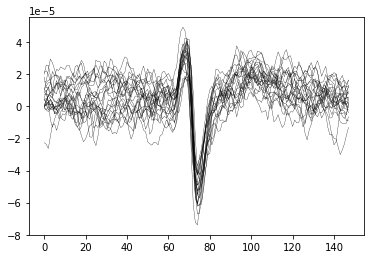

In [315]:
fig, ax = plt.subplots()
ax.plot(wf[2][:, 30, :].T, color='k', lw=0.3)

In [236]:
templates = st.postprocessing.get_unit_templates(loaded[u], sorted_dic[u], max_spikes_per_unit=200, 
                                                 save_as_property=True, verbose=True)

In [258]:
unitframe[(unitframe['qm_snr']>=0.1)]


unit_ids  max_channel  n_spikes  firing_rate  firing_rate_2 channellabel  \
0           0          0.0     471.0     1.570000       1.570000          R12   
1           1          0.0     643.0     2.143333       2.143333          R12   
2          10         30.0      23.0     0.076667       0.076667          O11   
3         100        134.0     197.0     0.656667       0.656667           F8   
4         101         91.0    1136.0     3.786667       3.786667           G2   
..        ...          ...       ...          ...            ...          ...   
742        95         61.0     673.0     2.243333       2.243333          I14   
743        96         71.0     357.0     1.190000       1.190000          R10   
744        97         71.0    1174.0     3.913333       3.913333          R10   
745        98         81.0     470.0     1.566667       1.566667           P1   
746        99         91.0      75.0     0.250000       0.250000           G2   

     ft_peak_to_valley  ft_halfwidth  ft_peak_trough_ratio  \
0              0.00028       0.00016             -0.217778   
1              0.00072       0.00020             -0.406593   
2              0.00104       0.00024             -0.378968   
3              0.00116       0.00576              0.801047   
4              0.00116       0.00020             -0.130909   
..                 ...           ...                   ...   
742            0.00088       0.00036             -0.237921   
743            0.00076       0.00024             -0.178694   
744            0.00028       0.00024             -0.232653   
745            0.00056       0.00016             -0.184000   
746            0.00048       0.00036             -0.309417   

     ft_repolarization_slope  ft_recovery_slope  qm_firing_rate  \
0                   0.096874          -0.001101        1.570000   
1                   0.031730          -0.004369        2.143333   
2                   0.198163          -0.015376        0.076667   
3                        NaN          -0.002177        0.656667   
4                   0.019108          -0.003019        3.786667   
..                       ...                ...             ...   
742                 0.144965          -0.014230        2.243333   
743                 0.054005          -0.004573        1.190000   
744                 0.065513          -0.006351        3.913333   
745                 0.053292          -0.002263        1.566667   
746                 0.076512          -0.013180        0.250000   

     qm_isi_violation     qm_snr  qm_amplitude_cutoff  qm_presence_ratio  
0            1.370594   3.861756             0.014265               1.00  
1            2.696499   3.123731             0.029983               1.00  
2            0.000000  13.500068             0.011251               0.17  
3            5.223085   4.189232             0.500000               0.87  
4            5.733182   4.085365             0.124681               1.00  
..                ...        ...                  ...                ...  
742          0.447537  22.870489             0.054127               0.96  
743          1.590461   3.707802             0.000863               0.98  
744          0.220605   3.121689             0.000863               1.00  
745          0.917622   3.980520             0.000863               1.00  
746          0.000000   6.625720             0.358568               0.55  

[747 rows x 16 columns]

In [313]:
unitframe.loc[2]

unit_ids                          10
max_channel                       30
n_spikes                          23
firing_rate                0.0766667
firing_rate_2              0.0766667
channellabel                     O11
ft_peak_to_valley            0.00104
ft_halfwidth                 0.00024
ft_peak_trough_ratio       -0.378968
ft_repolarization_slope     0.198163
ft_recovery_slope          -0.015376
qm_firing_rate             0.0766667
qm_isi_violation                   0
qm_snr                       13.5001
qm_amplitude_cutoff        0.0112515
qm_presence_ratio               0.17
Name: 2, dtype: object

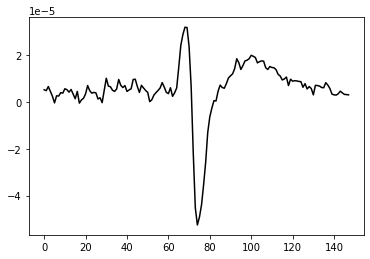

In [314]:
fig, ax = plt.subplots()
ax.plot(templates[2][30].T, color='k')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45

<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy


46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67

<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy


68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138

<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy


139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245


<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-310-4d029bc7174b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

246
247
248
249
250
251


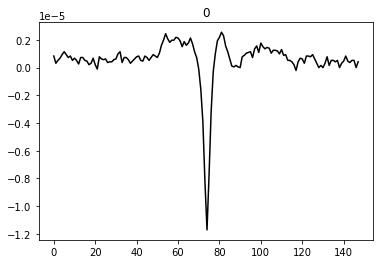

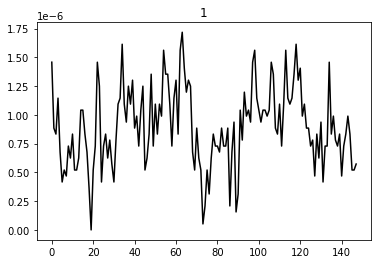

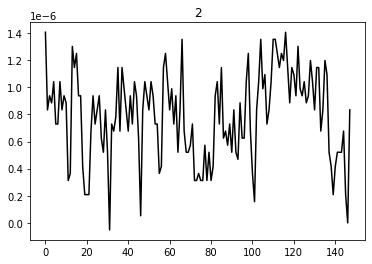

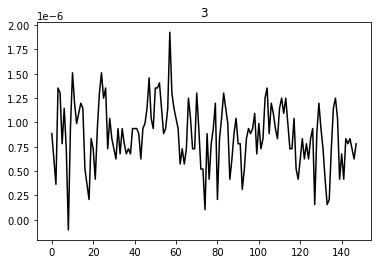

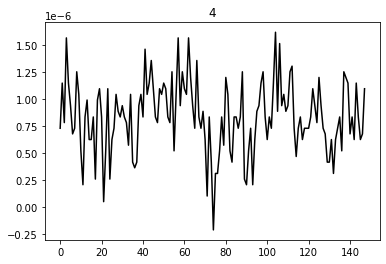

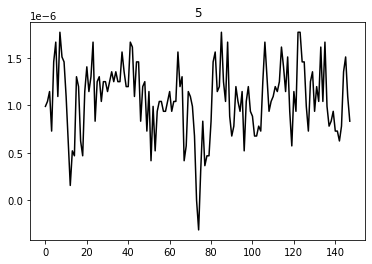

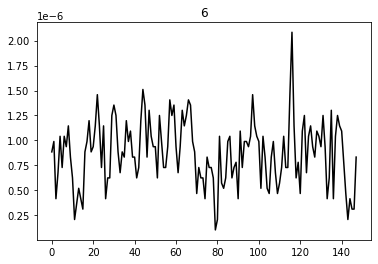

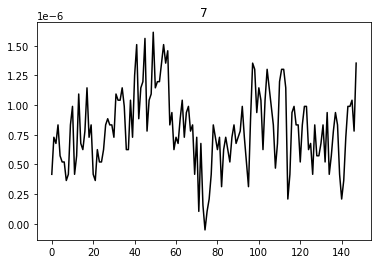

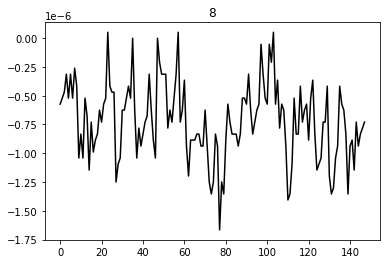

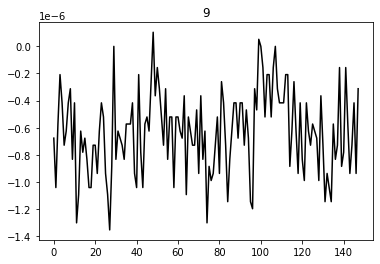

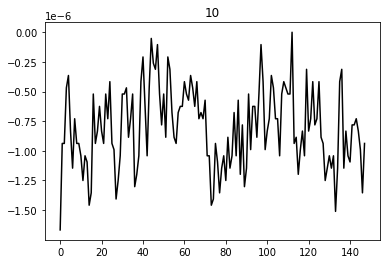

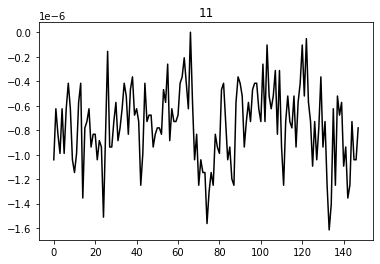

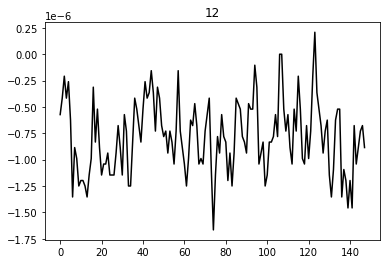

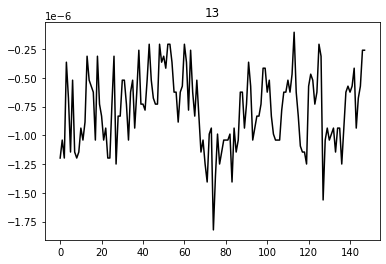

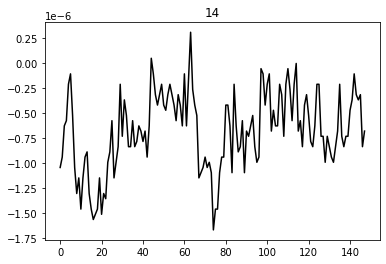

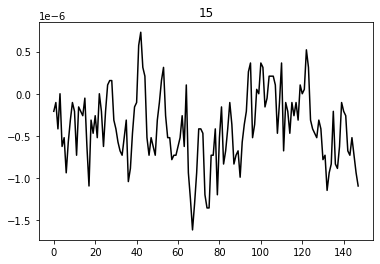

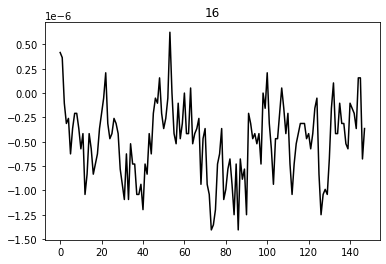

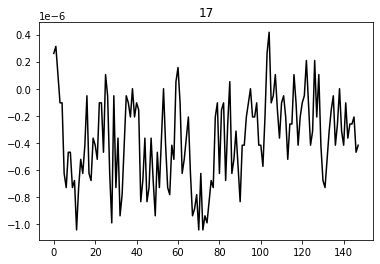

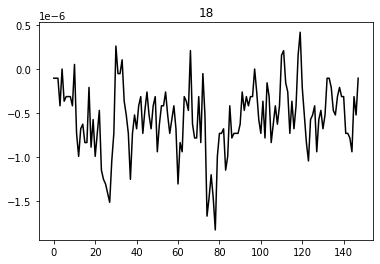

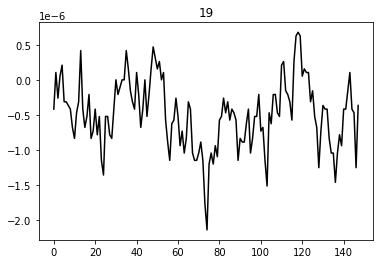

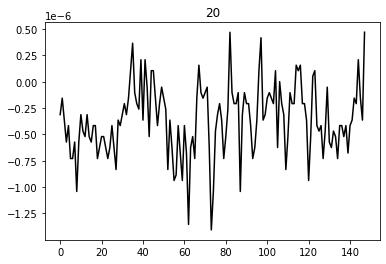

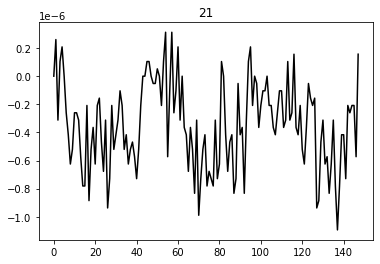

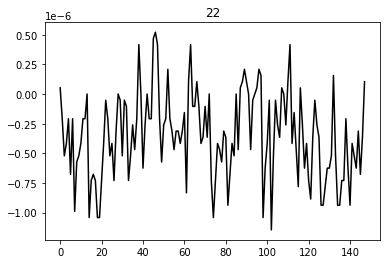

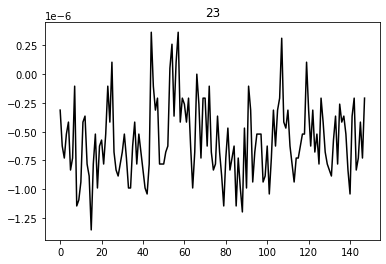

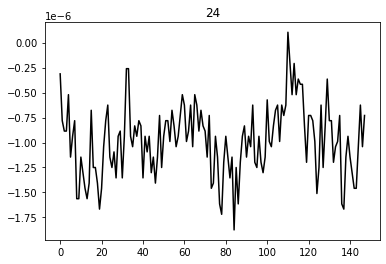

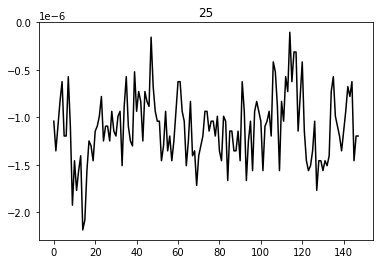

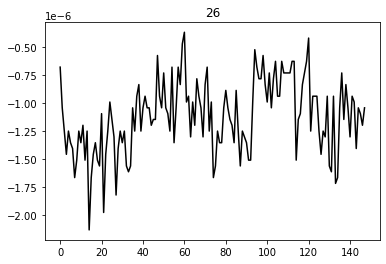

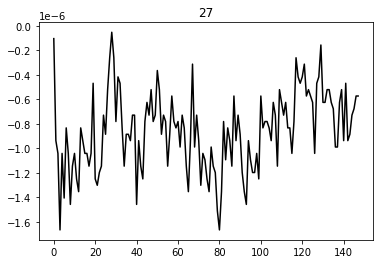

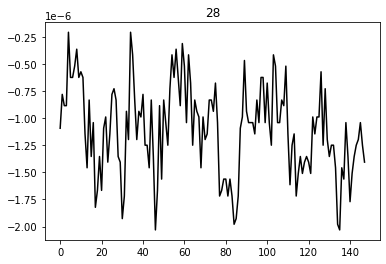

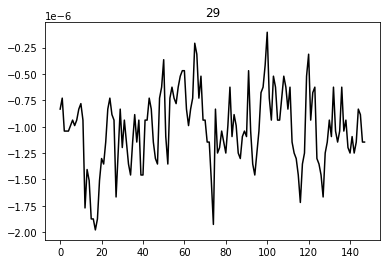

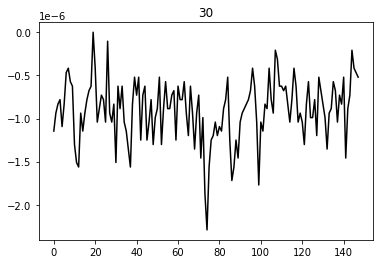

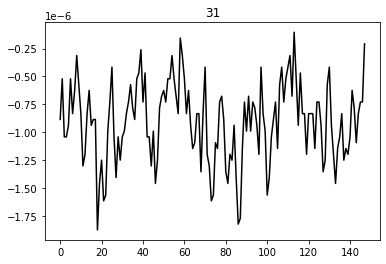

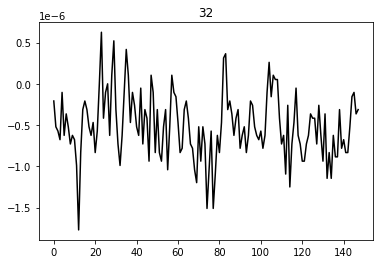

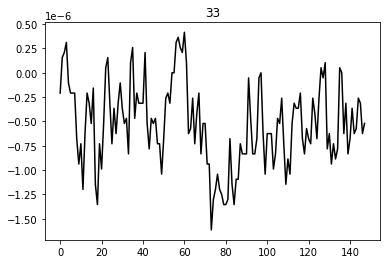

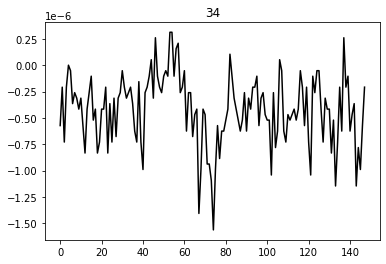

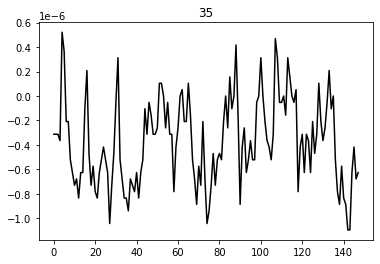

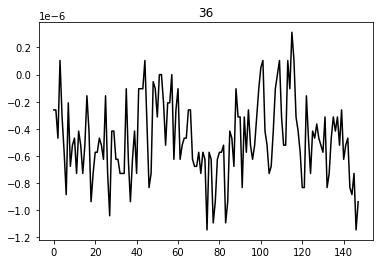

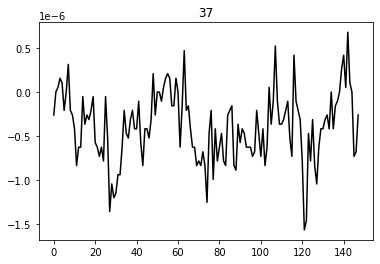

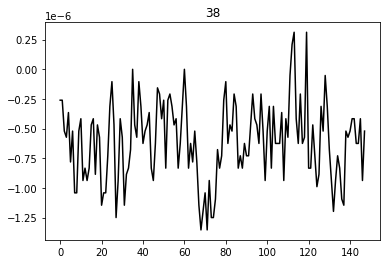

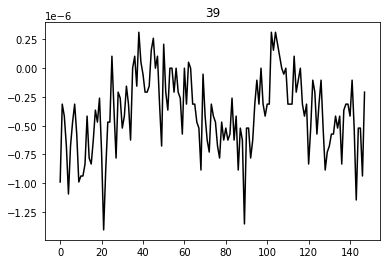

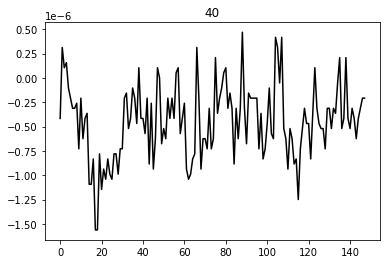

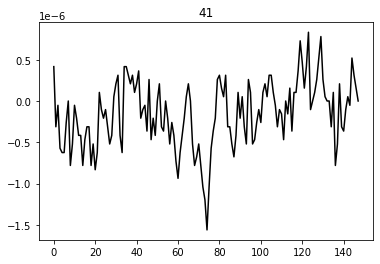

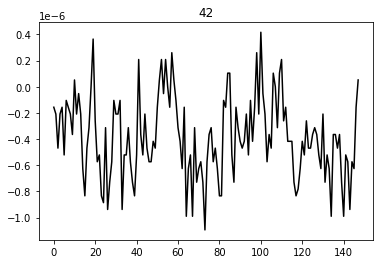

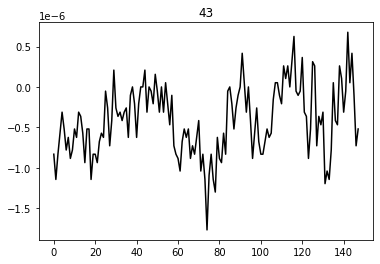

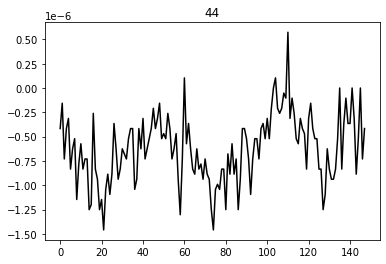

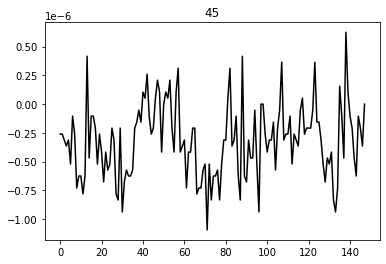

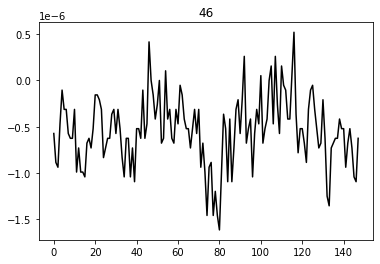

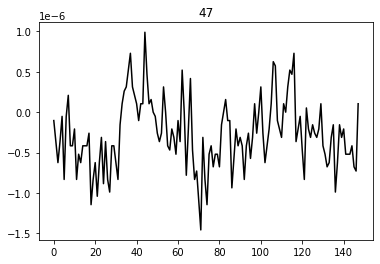

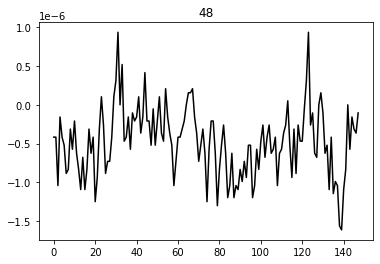

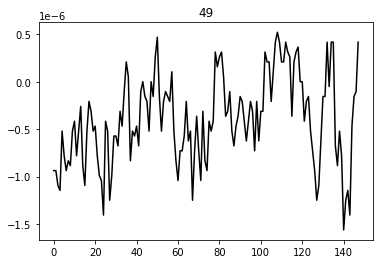

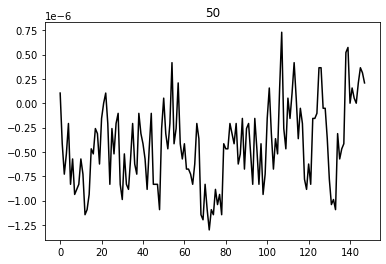

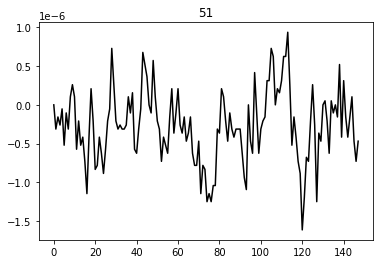

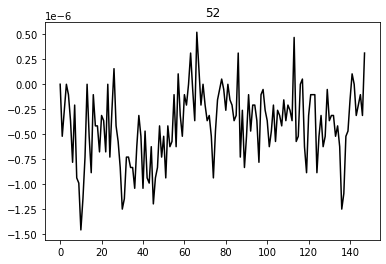

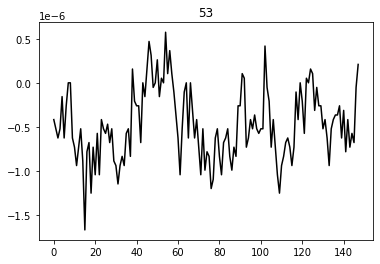

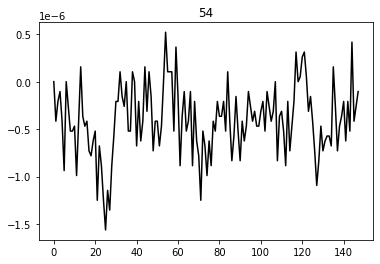

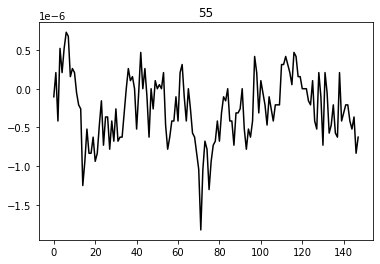

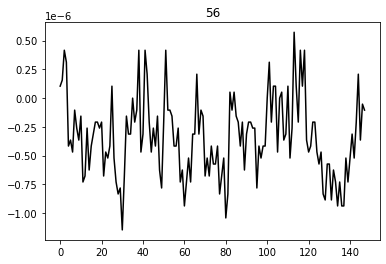

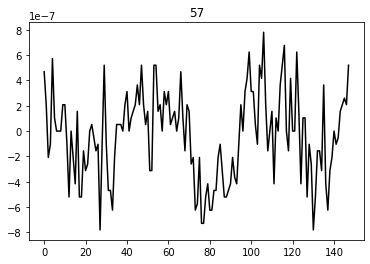

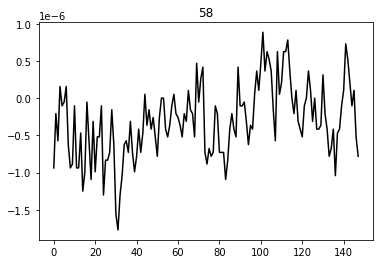

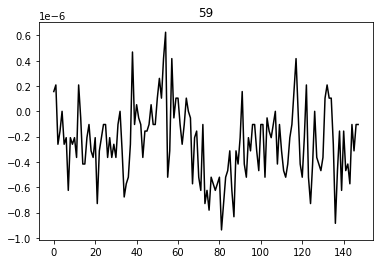

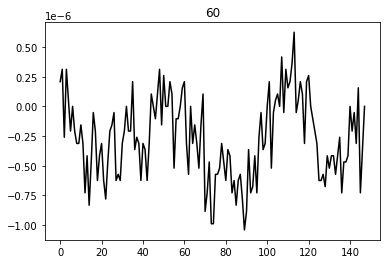

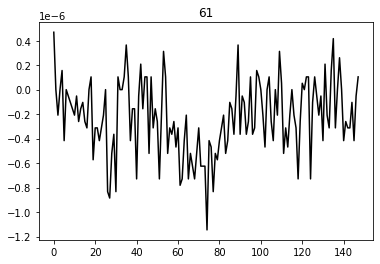

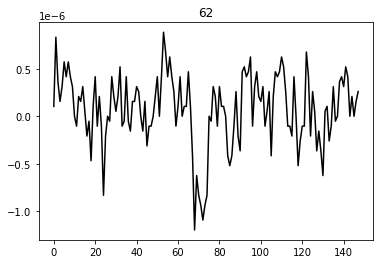

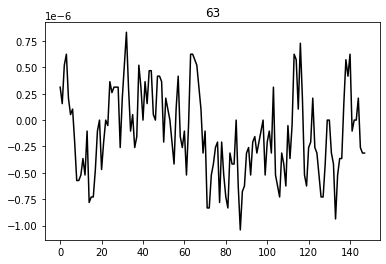

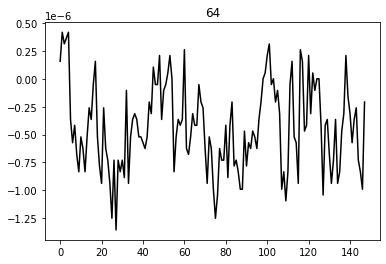

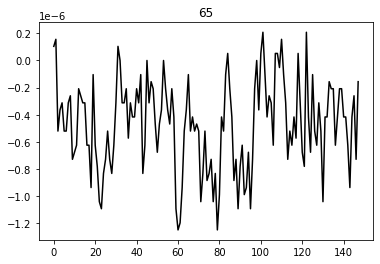

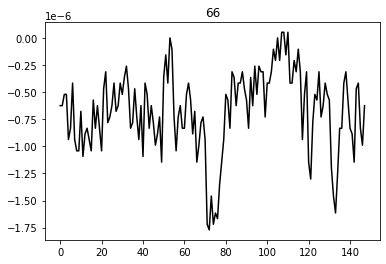

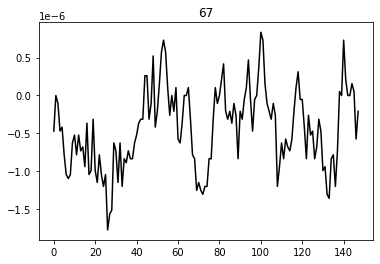

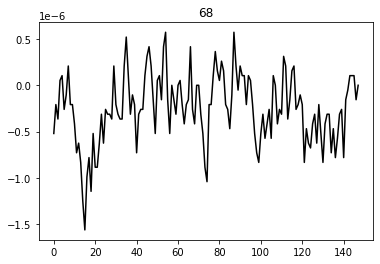

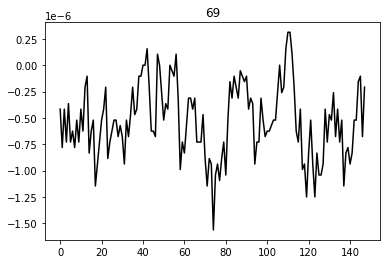

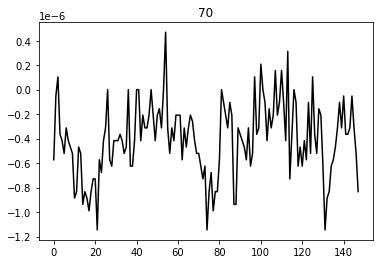

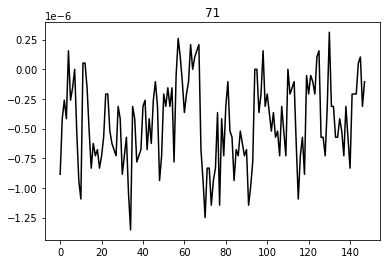

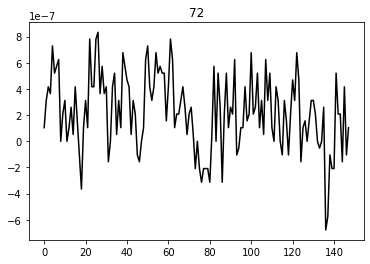

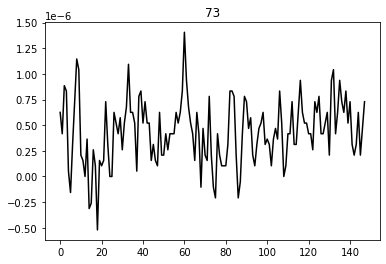

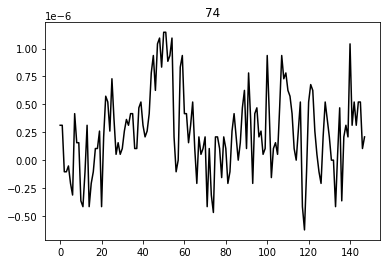

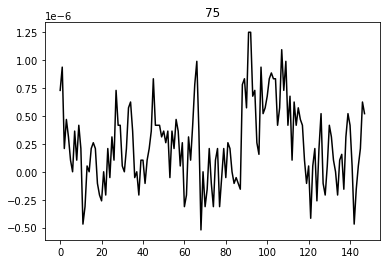

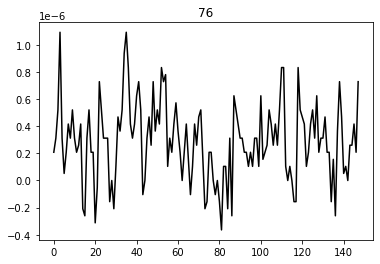

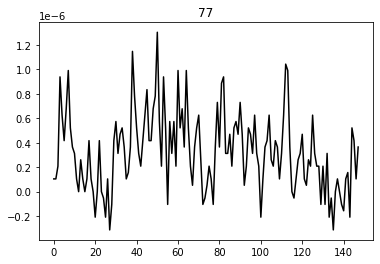

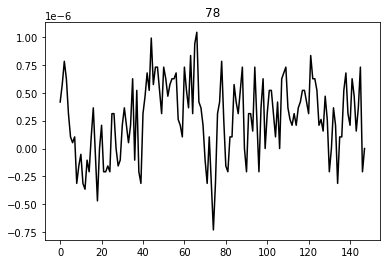

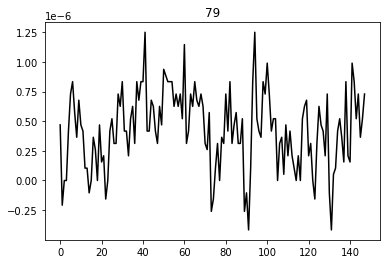

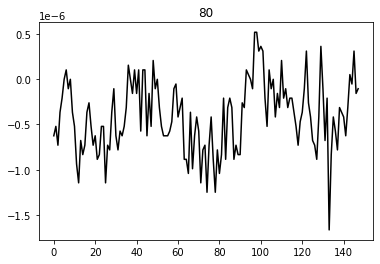

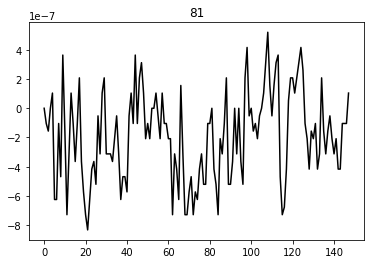

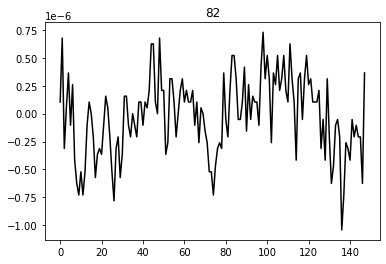

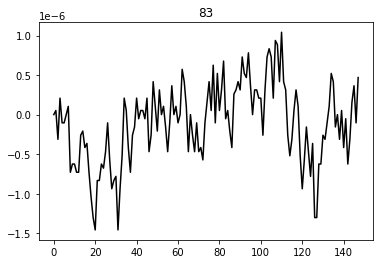

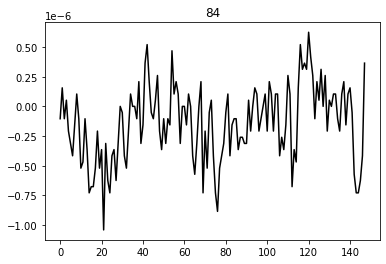

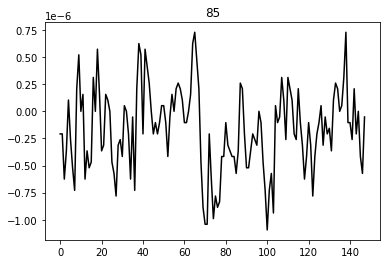

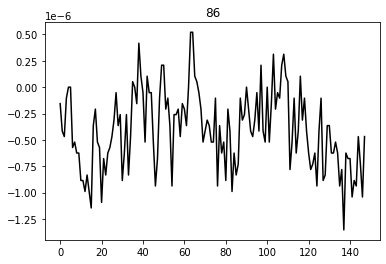

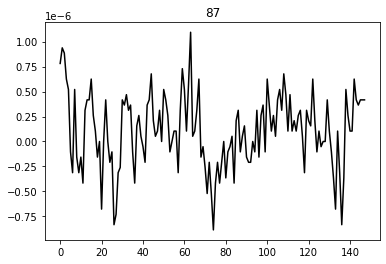

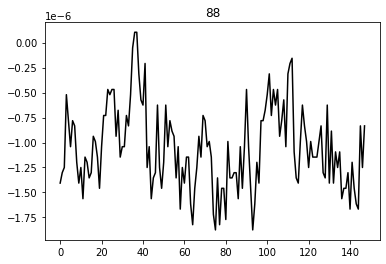

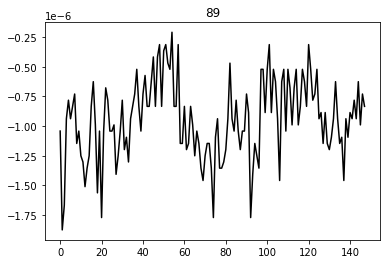

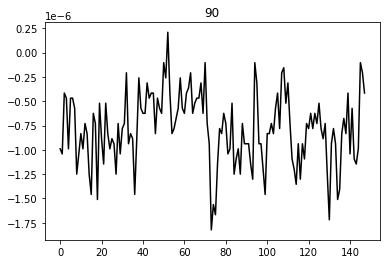

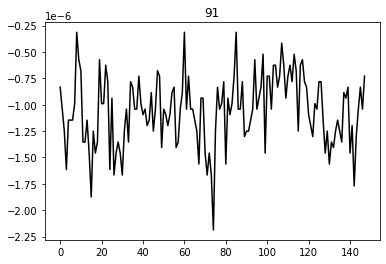

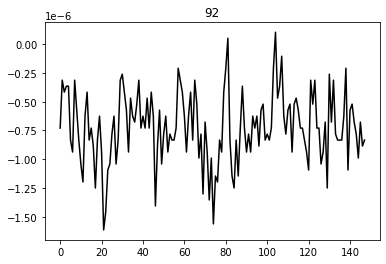

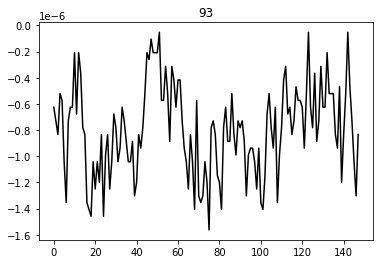

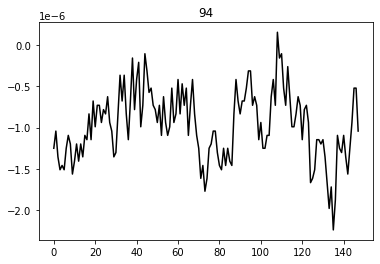

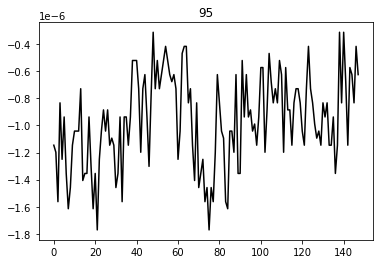

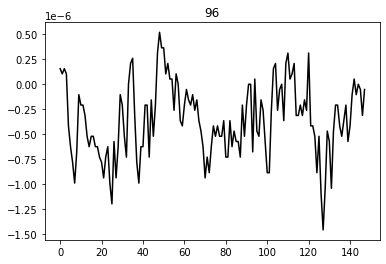

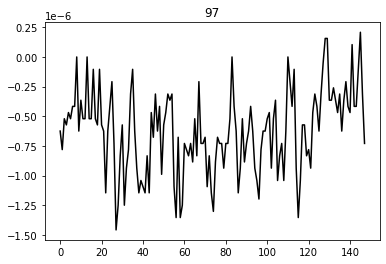

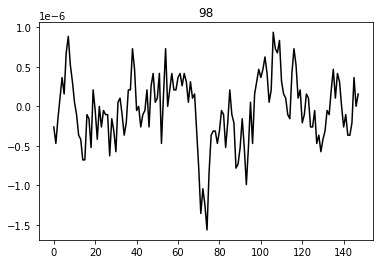

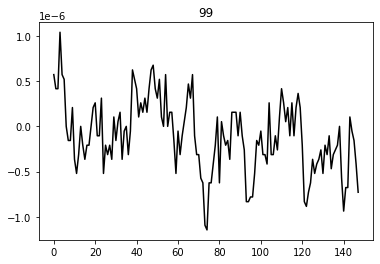

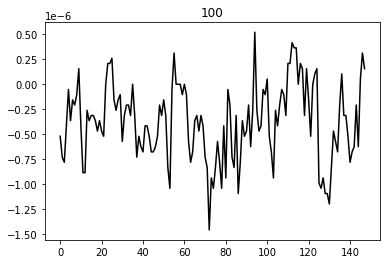

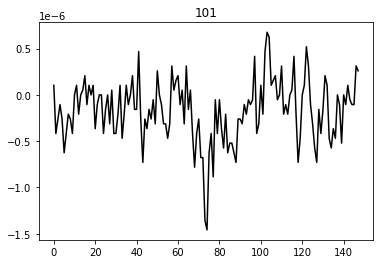

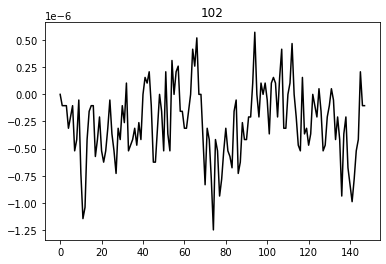

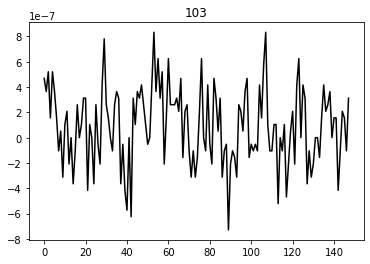

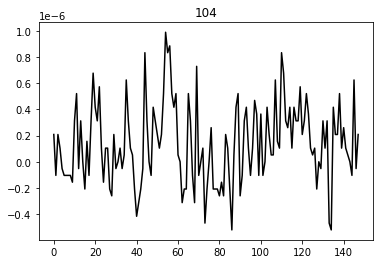

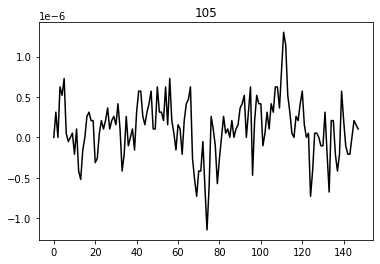

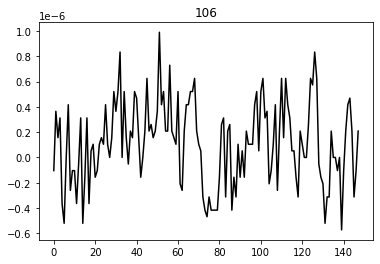

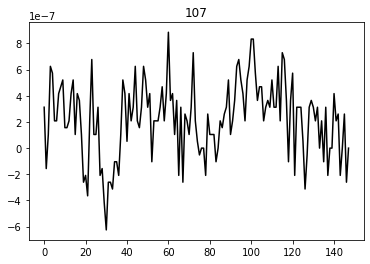

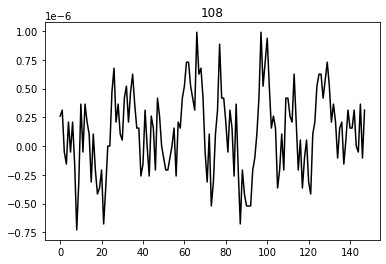

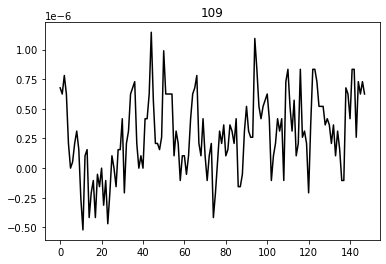

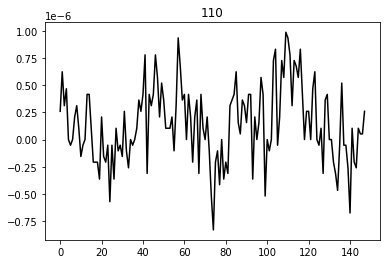

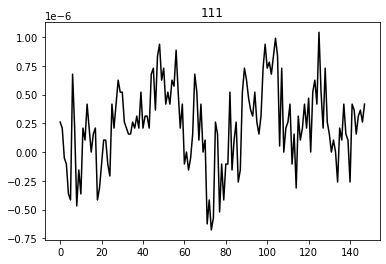

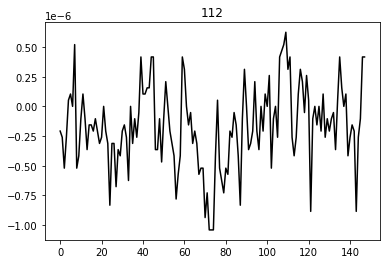

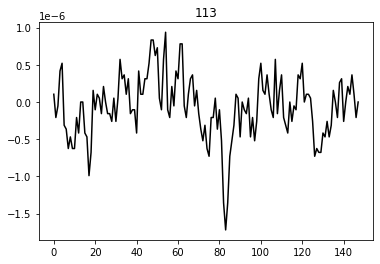

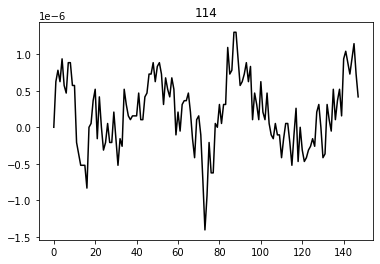

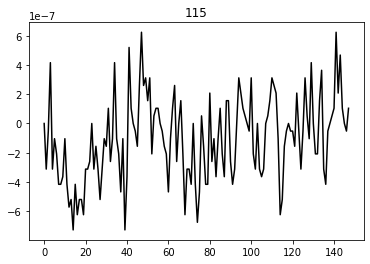

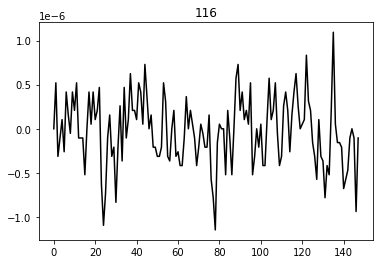

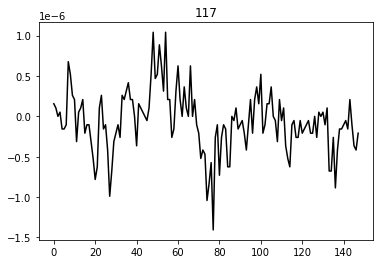

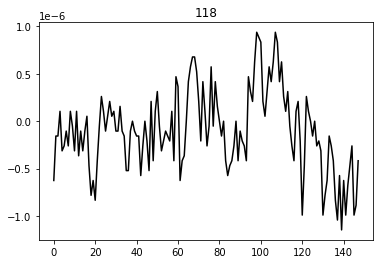

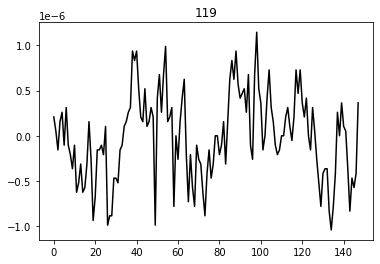

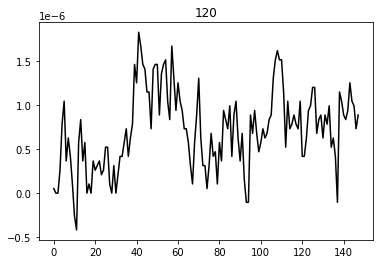

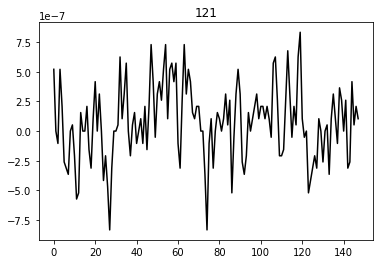

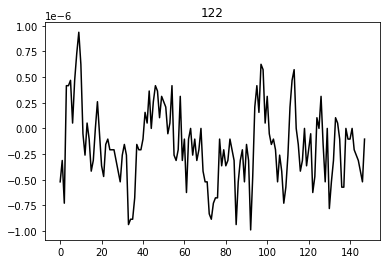

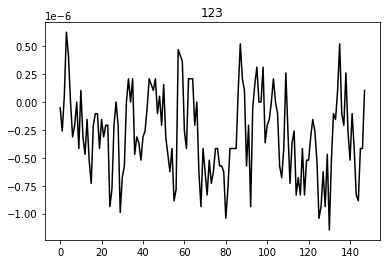

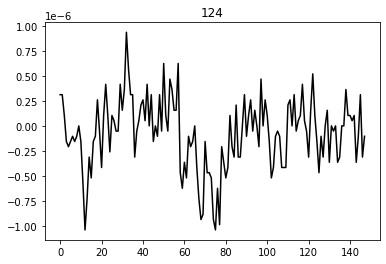

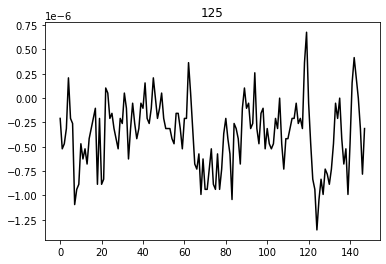

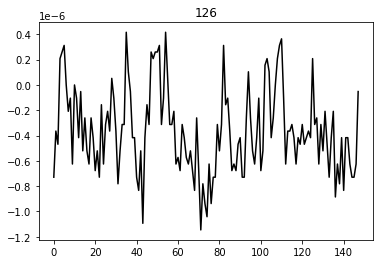

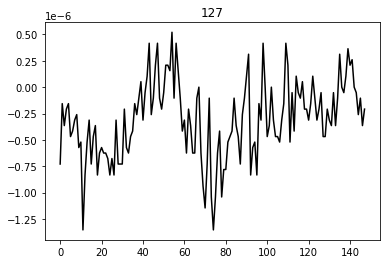

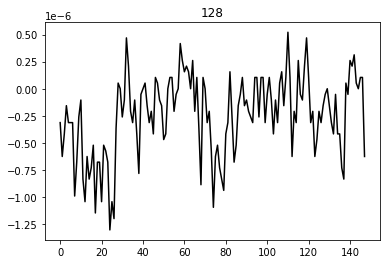

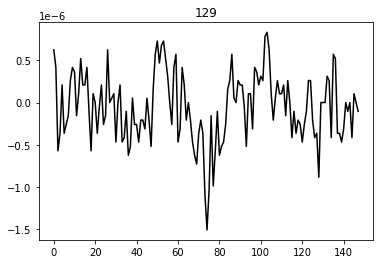

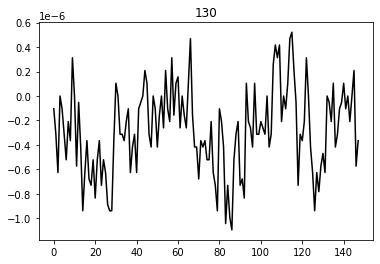

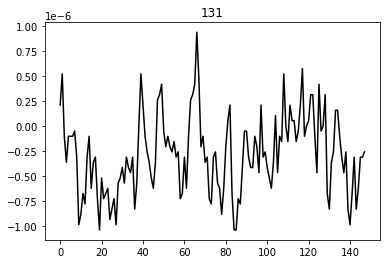

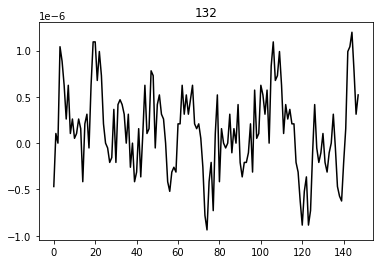

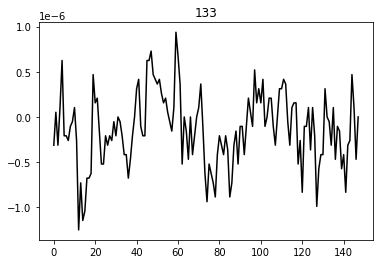

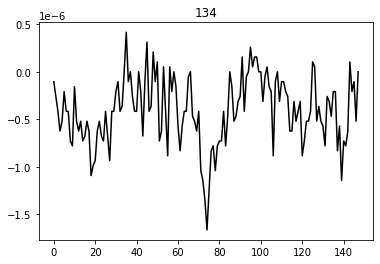

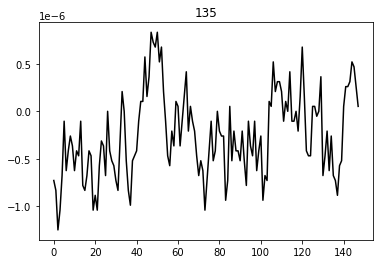

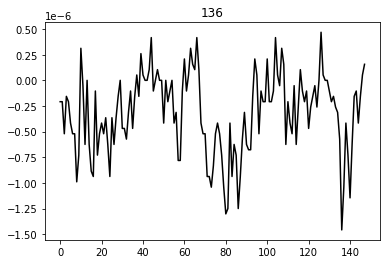

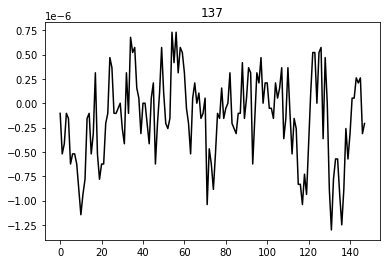

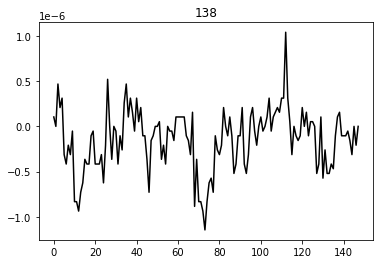

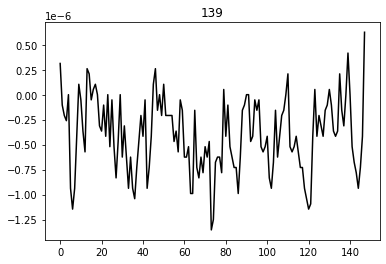

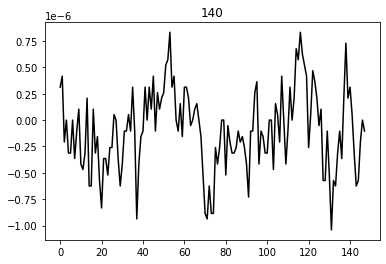

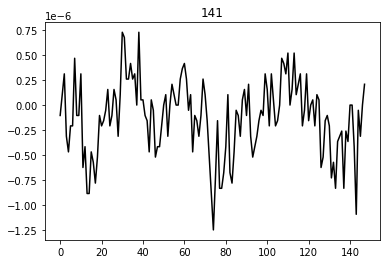

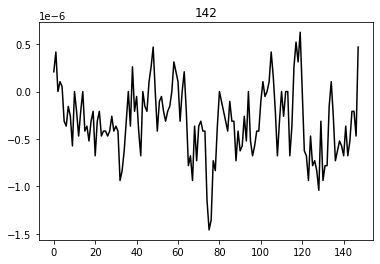

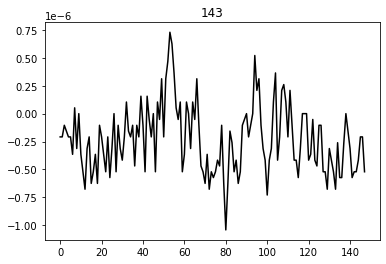

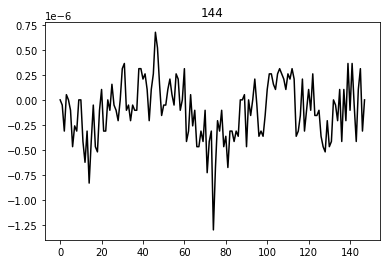

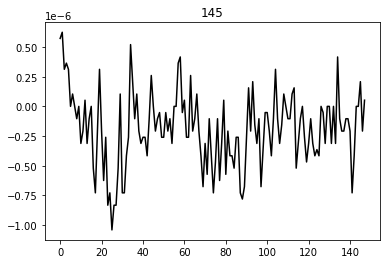

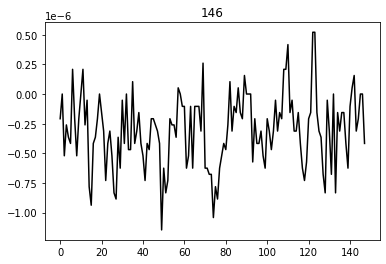

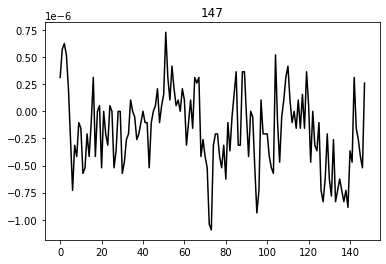

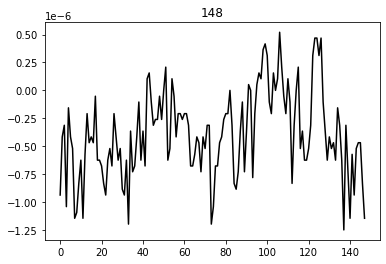

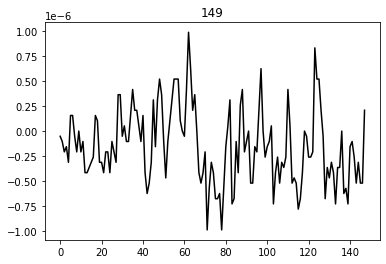

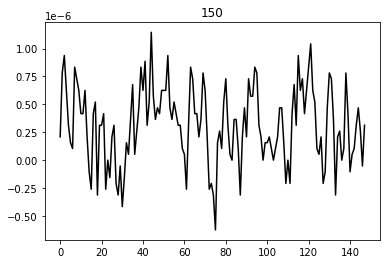

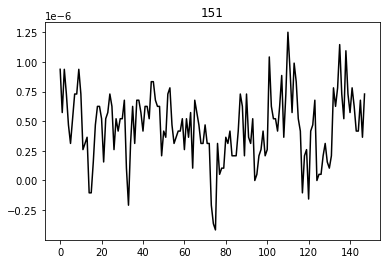

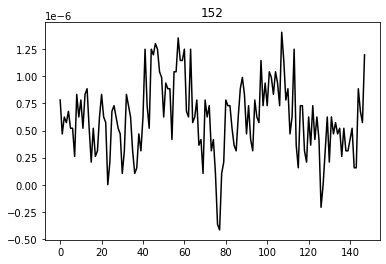

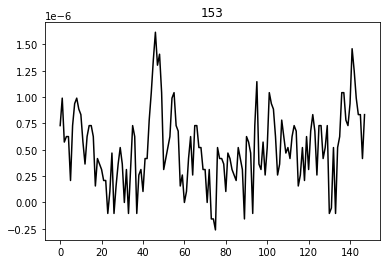

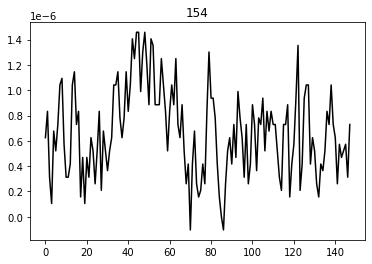

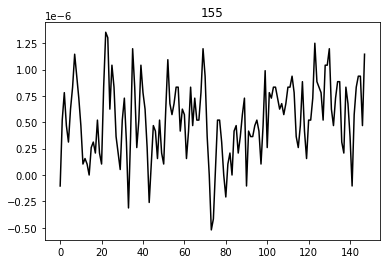

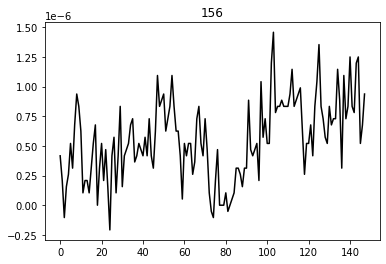

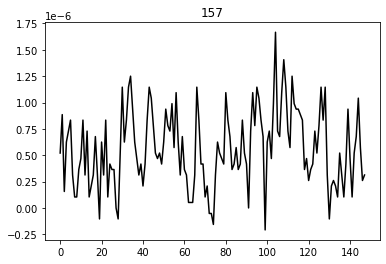

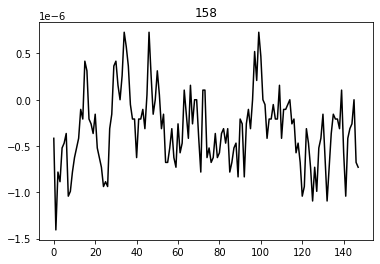

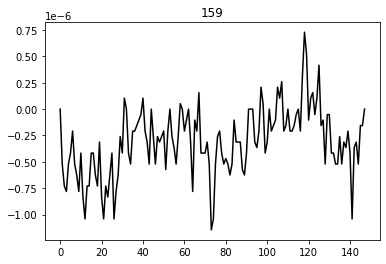

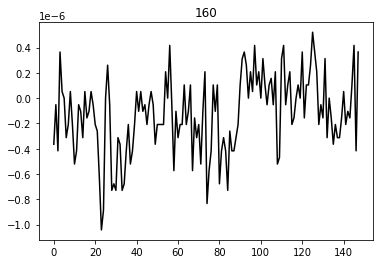

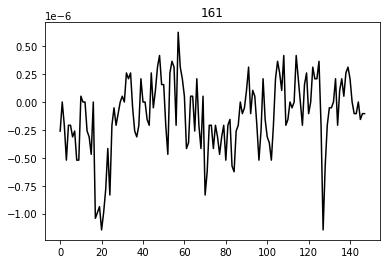

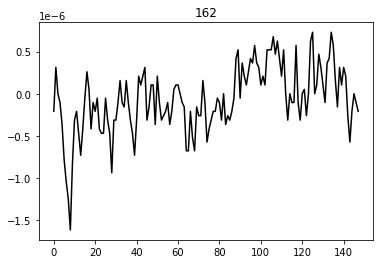

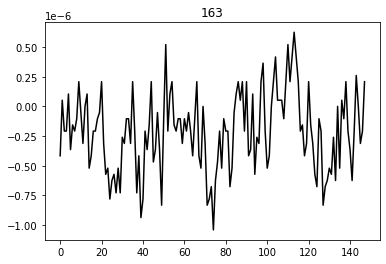

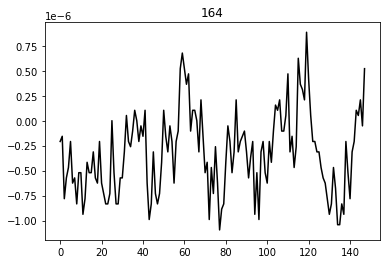

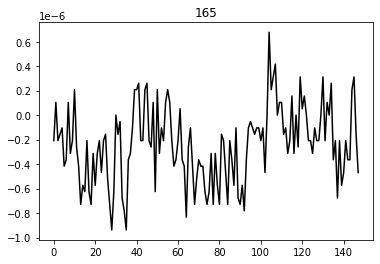

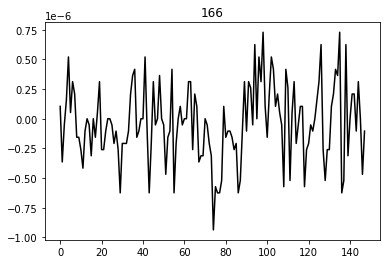

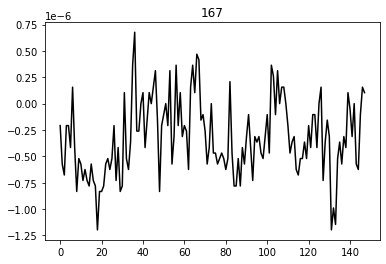

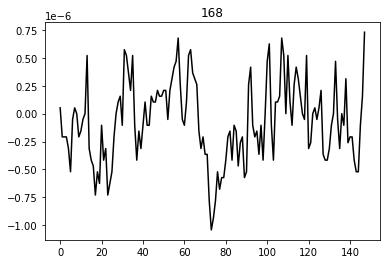

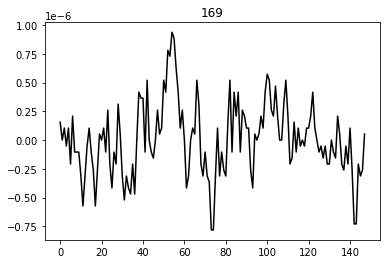

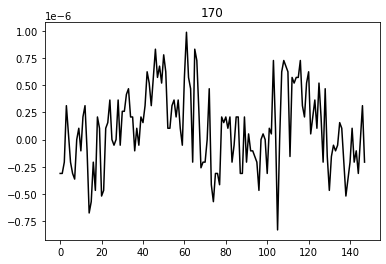

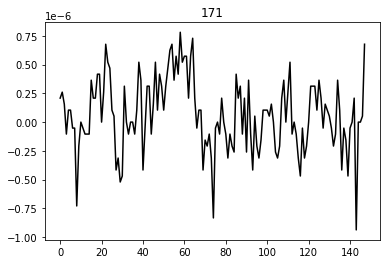

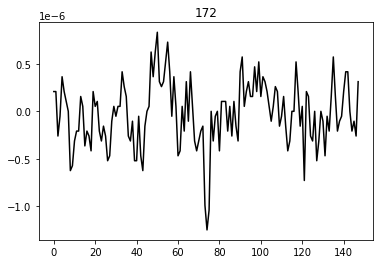

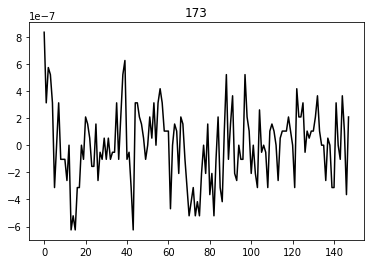

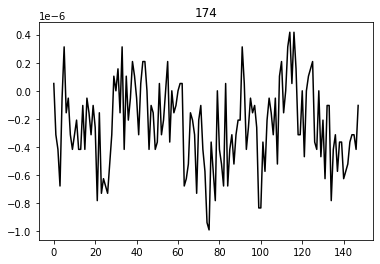

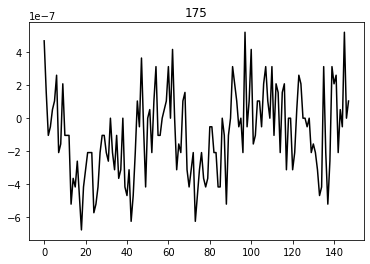

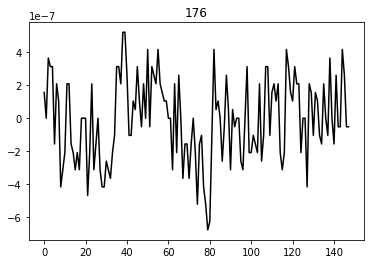

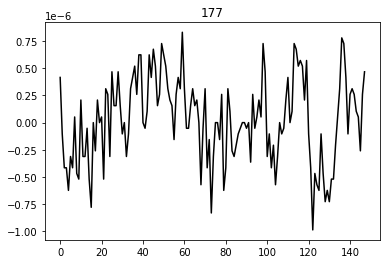

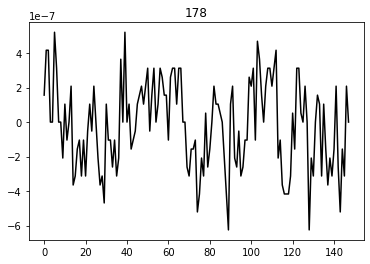

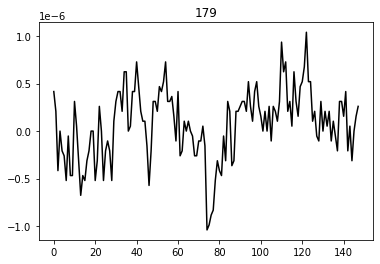

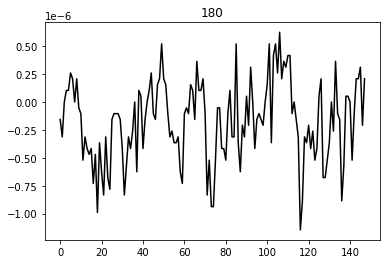

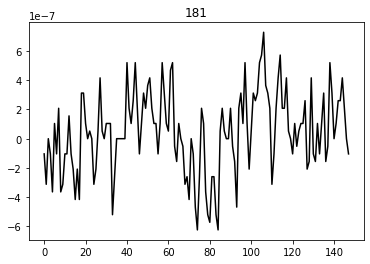

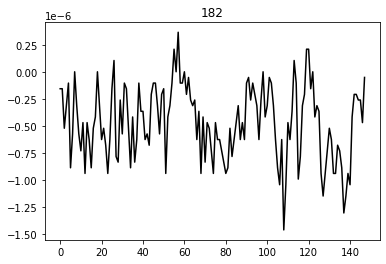

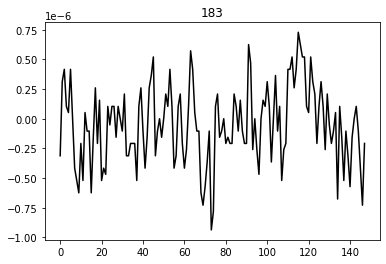

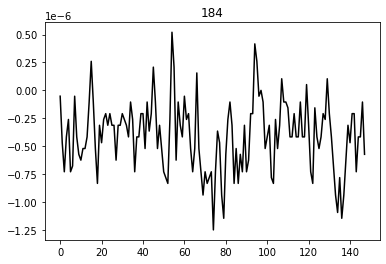

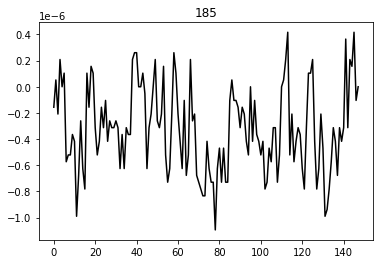

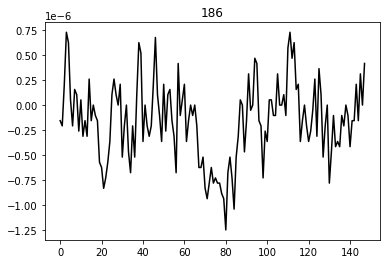

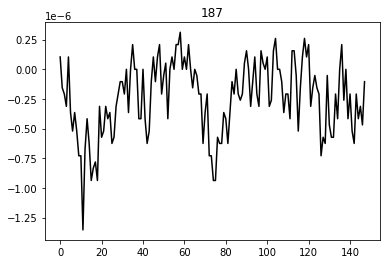

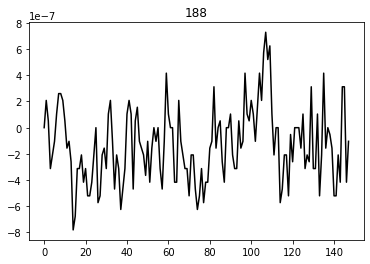

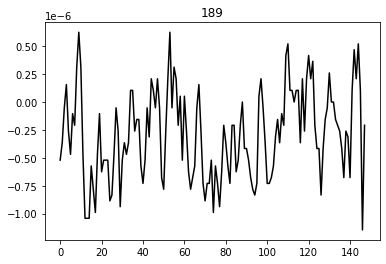

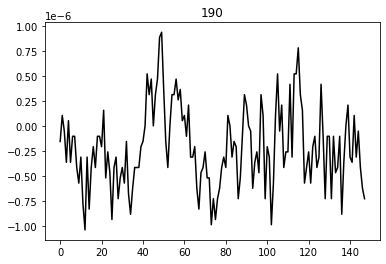

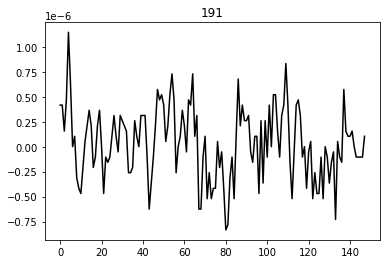

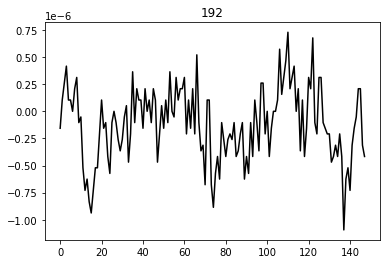

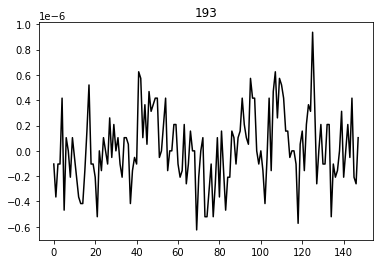

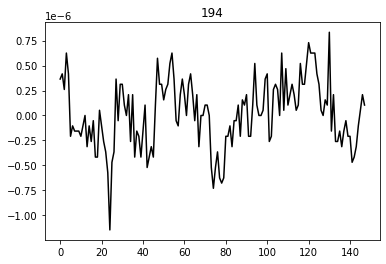

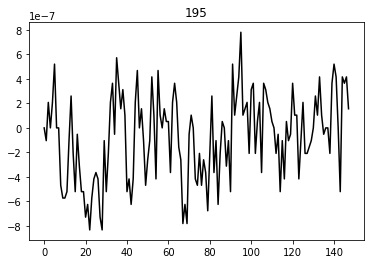

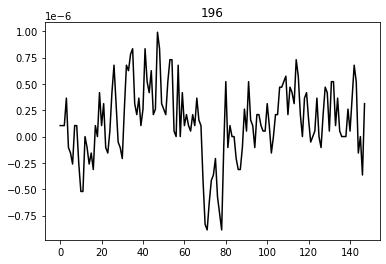

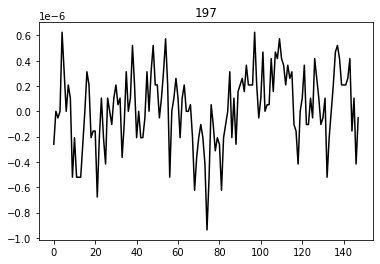

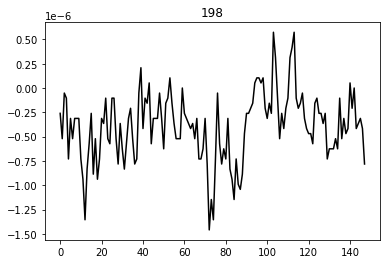

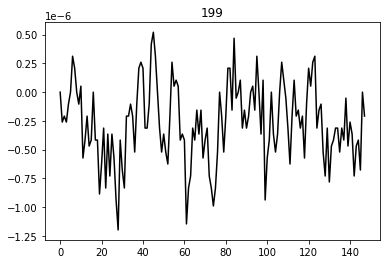

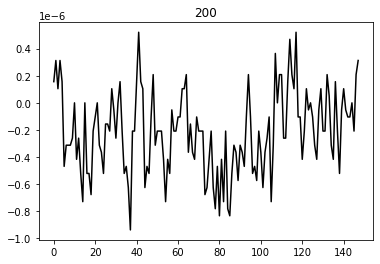

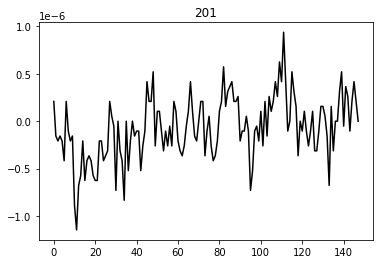

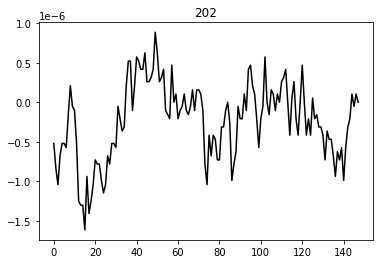

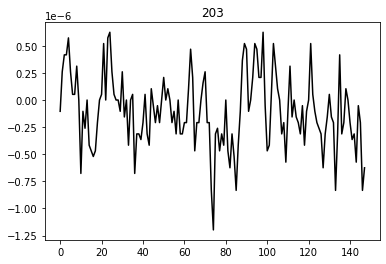

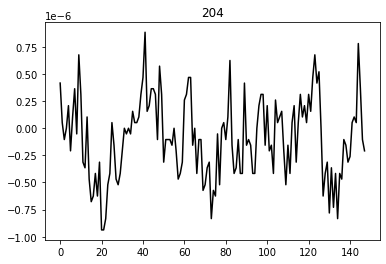

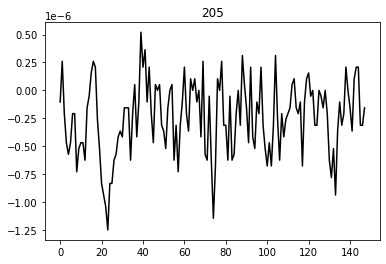

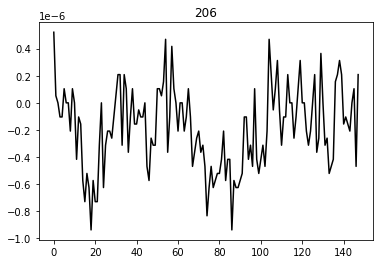

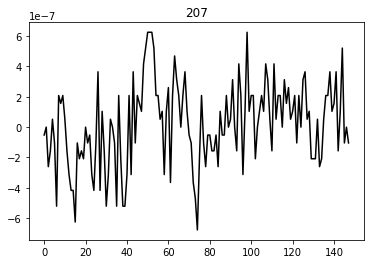

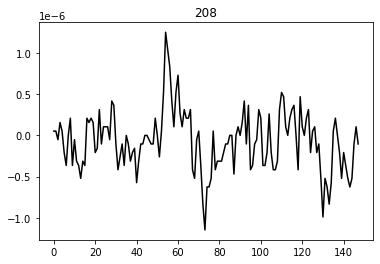

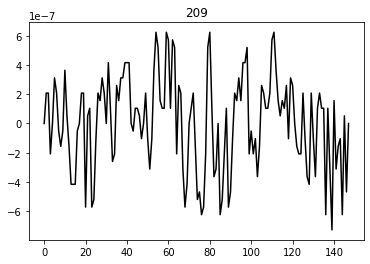

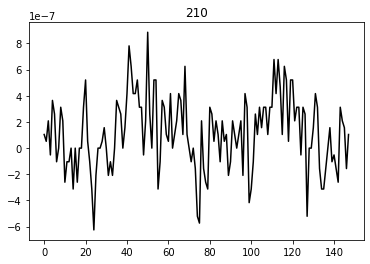

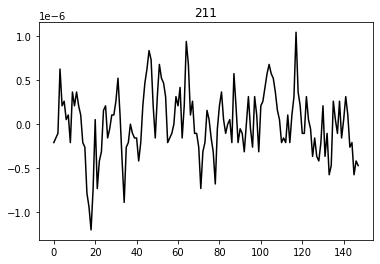

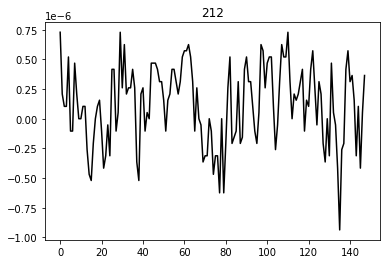

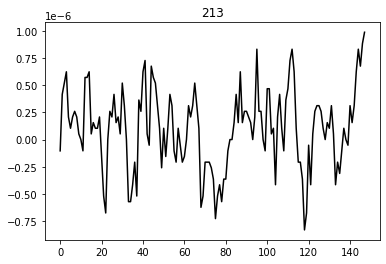

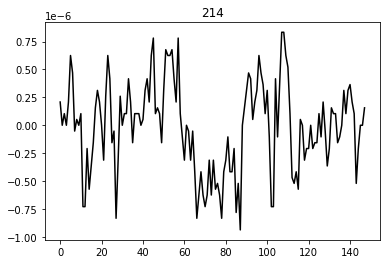

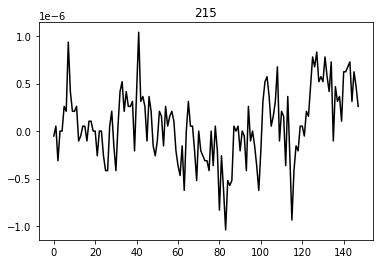

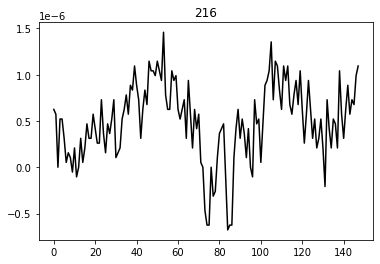

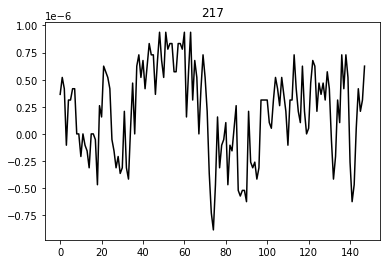

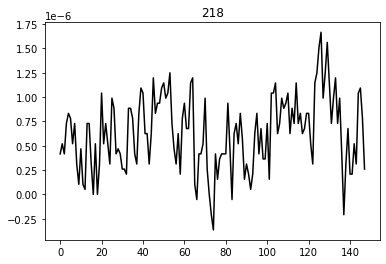

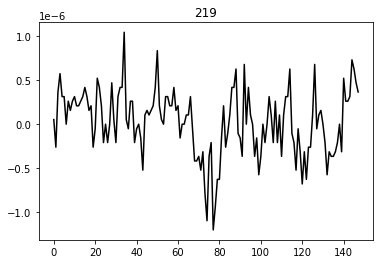

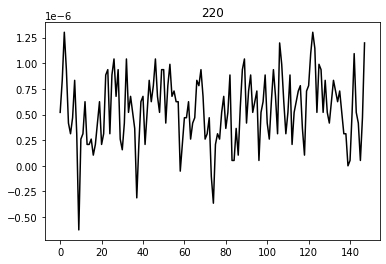

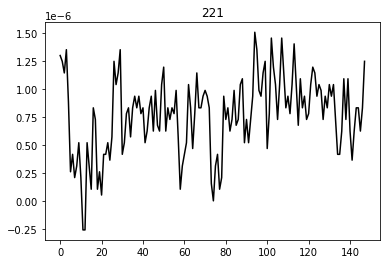

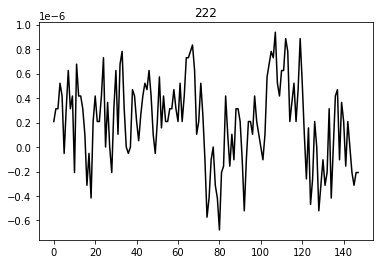

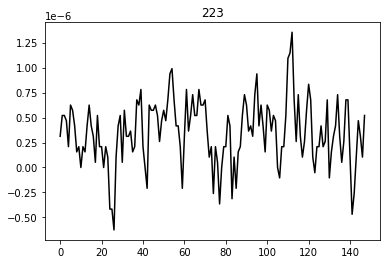

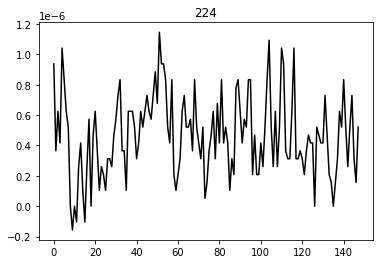

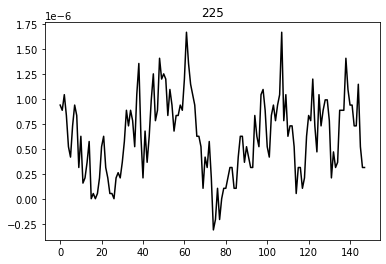

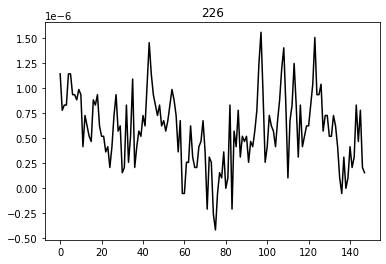

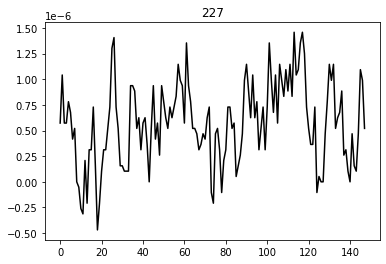

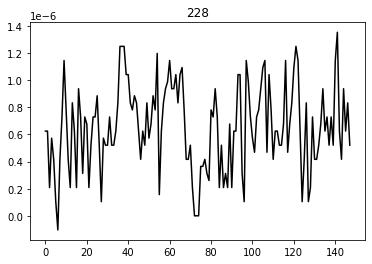

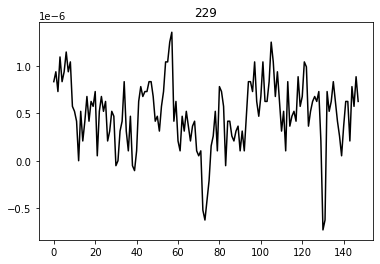

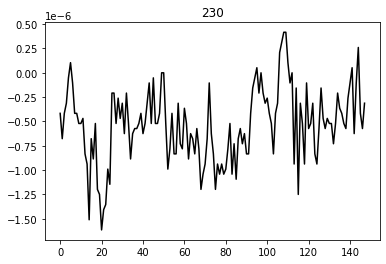

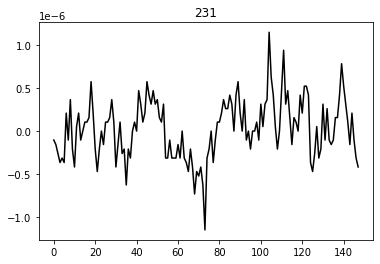

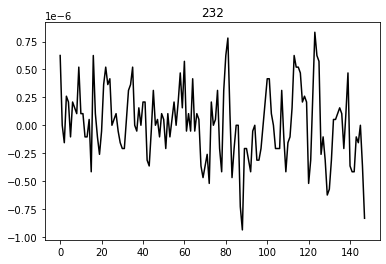

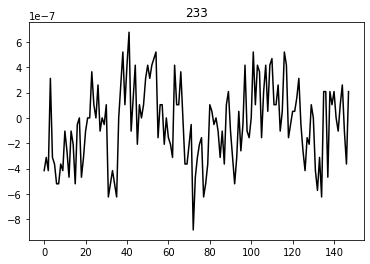

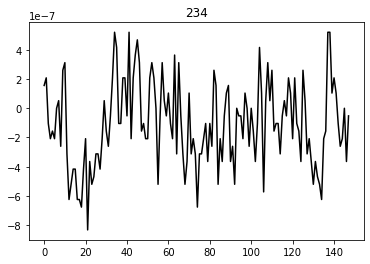

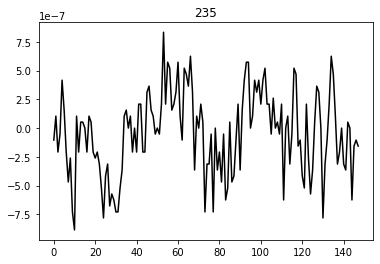

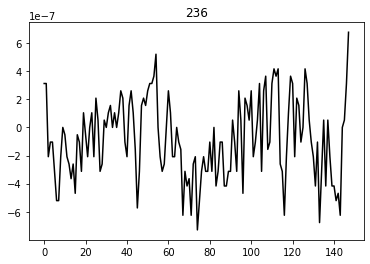

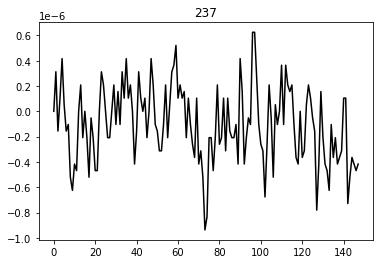

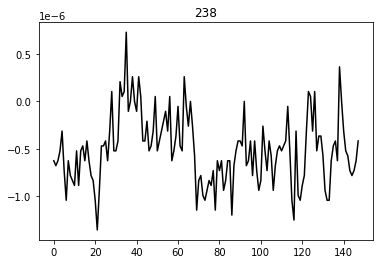

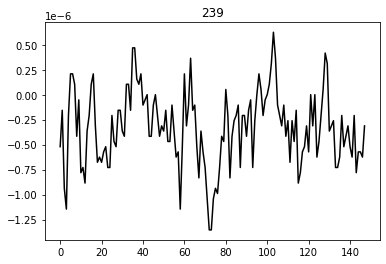

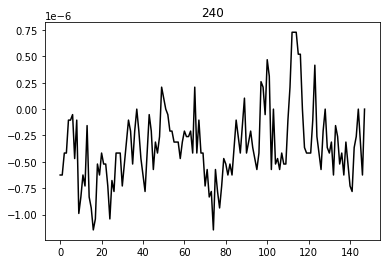

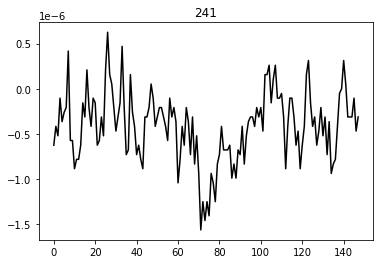

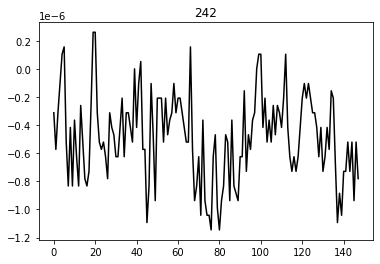

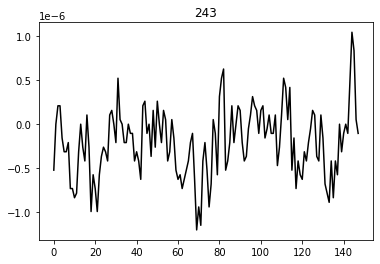

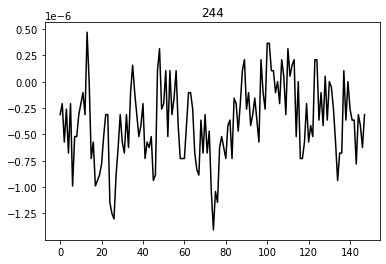

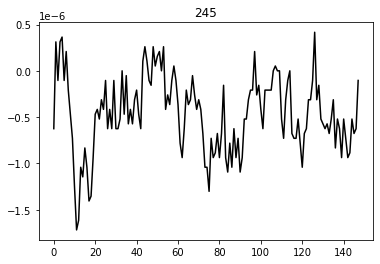

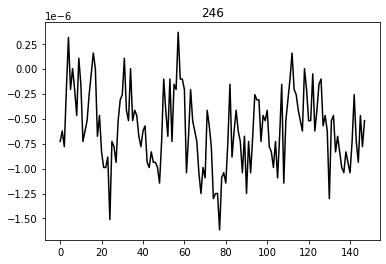

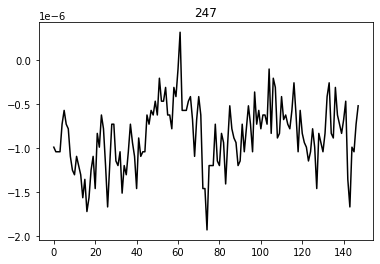

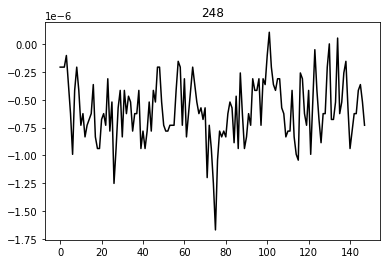

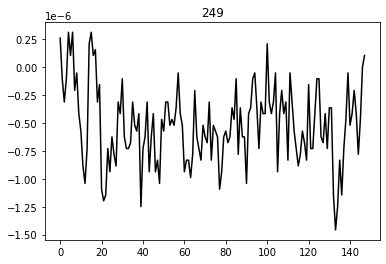

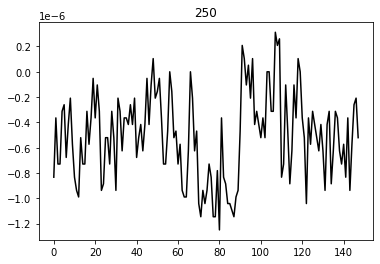

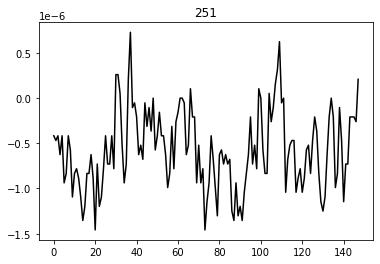

In [310]:
for i in range(0,252):
    print(i)
    fig, ax = plt.subplots()
    ax.plot(templates[0][i].T, color='k')
    ax.set_title(str(i))

In [308]:
labeldic[40]

'K7'

idee: templates pro channel darstellen -> also den dataframe nach channel sortieren, dich mit key: channel, value: units

In [345]:
unitlist_by_index = list(unitframe.loc[(unitframe['max_channel'])==1].index)

In [346]:
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==1]['unit_ids'])

In [347]:
unitlist_by_channel

[80, 81, 82]

In [367]:
unitframe[:10]

unit_ids  max_channel  n_spikes  firing_rate  firing_rate_2 channellabel  \
0         0          0.0     471.0     1.570000       1.570000          R12   
1         1          0.0     643.0     2.143333       2.143333          R12   
2        10         30.0      23.0     0.076667       0.076667          O11   
3       100        134.0     197.0     0.656667       0.656667           F8   
4       101         91.0    1136.0     3.786667       3.786667           G2   
5       102         91.0     273.0     0.910000       0.910000           G2   
6       103         91.0     155.0     0.516667       0.516667           G2   
7       104         91.0     514.0     1.713333       1.713333           G2   
8       105        134.0     380.0     1.266667       1.266667           F8   
9       106        101.0    1993.0     6.643333       6.643333          P10   

   ft_peak_to_valley  ft_halfwidth  ft_peak_trough_ratio  \
0            0.00028       0.00016             -0.217778   
1            0.00072       0.00020             -0.406593   
2            0.00104       0.00024             -0.378968   
3            0.00116       0.00576              0.801047   
4            0.00116       0.00020             -0.130909   
5            0.00112       0.00040             -0.271084   
6            0.00056       0.00028             -0.171271   
7            0.00140       0.00036             -0.098592   
8            0.00112       0.00584              0.650386   
9            0.00076       0.00024             -0.205240   

   ft_repolarization_slope  ft_recovery_slope  qm_firing_rate  \
0                 0.096874          -0.001101        1.570000   
1                 0.031730          -0.004369        2.143333   
2                 0.198163          -0.015376        0.076667   
3                      NaN          -0.002177        0.656667   
4                 0.019108          -0.003019        3.786667   
5                 0.042661          -0.006376        0.910000   
6                 0.058810          -0.007353        0.516667   
7                 0.035113           0.000022        1.713333   
8                      NaN          -0.002995        1.266667   
9                 0.060974          -0.003070        6.643333   

   qm_isi_violation     qm_snr  qm_amplitude_cutoff  qm_presence_ratio  
0          1.370594   3.861756             0.014265               1.00  
1          2.696499   3.123731             0.029983               1.00  
2          0.000000  13.500068             0.011251               0.17  
3          5.223085   4.189232             0.500000               0.87  
4          5.733182   4.085365             0.124681               1.00  
5          1.359891   4.932150             0.051056               0.91  
6          8.437157   5.377827             0.143443               0.75  
7          4.987084   3.164301             0.066102               0.98  
8          2.807517   4.265998             0.500000               0.97  
9          0.178613   2.896008             0.016280               1.00

In [385]:
j = 0
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
print(unitlist_by_index)
unitframe.loc[unitlist_by_index[0]]['channellabel']

Int64Index([0, 1], dtype='int64')


'R12'

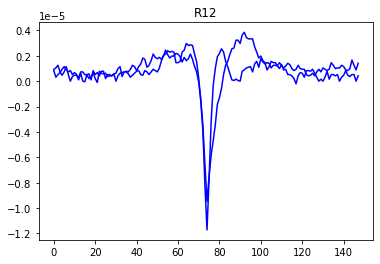

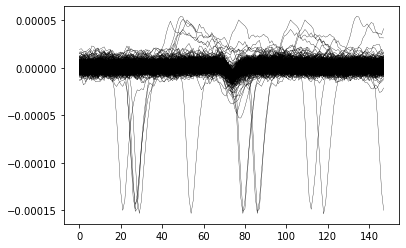

In [386]:

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

for i in unitlist_by_index:
    ax.plot(templates[i][j].T, color='b')
    ax.set_title(str(unitframe.loc[i]['channellabel']))

    

    ax2.plot(wf[i][:, j, :].T, color='k', lw=0.3)



In [352]:
unitframe[726]

KeyError: 726

In [204]:
unitlist_by_channel

[0, 1]

In [335]:
labeldic[1]

'L10'

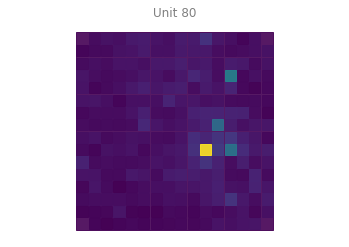

In [336]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[80])

In [ ]:
Continue 20/04:
    - fill in the dataframe with the other parameters
    - dump/pickle the data frame
    - make a plot for every unit

In [ ]:
waveforms = st.postprocessing.get_unit_waveforms(loaded['sec_0-300'], sorted_dic['sec_0-300'], ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [125]:
u = 'sec_0-300'

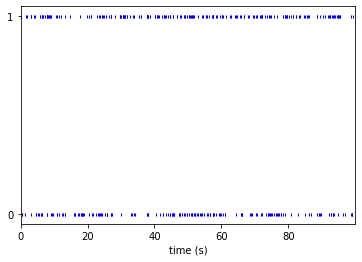

In [299]:
sw.plot_rasters(sorted_dic[u], color='b', unit_ids=[0, 1], trange=[0,100])

NEXT: PANDAS DF mit rows für die unit, columns: channel, number of spikes, firing rate, from channel -> layer, quality metrics, template features, 



In [83]:
st.validation.get_quality_metrics_list()

['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

In [201]:
features = st.postprocessing.compute_unit_template_features(
    loaded, sorted_dic['sec_0-300'], as_dataframe=False, upsampling_factor=10
    )

AttributeError: 'dict' object has no attribute 'get_channel_ids'

In [55]:
features

peak_to_valley  halfwidth  peak_trough_ratio  repolarization_slope  \
0          0.000744   0.000124          -0.265574              0.075042   
1          0.000820   0.000328          -0.474439              0.027238   
10         0.000916   0.000316          -0.314959              0.039820   
100        0.000548   0.000248          -0.086883              0.046373   
101        0.002952   0.000232           0.015183                   NaN   
..              ...        ...                ...                   ...   
95         0.000616   0.000284          -0.342646              0.052901   
96         0.000376   0.000196          -0.217725              0.053803   
97         0.000484   0.000172          -0.412964              0.056041   
98         0.001016   0.000332          -0.178314              0.190320   
99         0.000924   0.000332          -0.159931              0.194649   

     recovery_slope  
0         -0.000977  
1         -0.002525  
10        -0.008185  
100       -0.001005  
101             NaN  
..              ...  
95        -0.008465  
96        -0.001766  
97        -0.006332  
98        -0.016595  
99        -0.014851  

[502 rows x 5 columns]

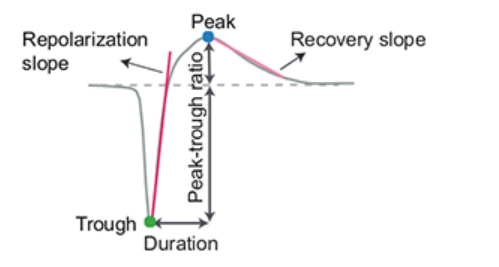

In [53]:

duration = recording_cache.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_SC, duration_in_frames=duration)
print('ISI violations:', isi_violations)



ISI violations: [1.27377826e+00 0.00000000e+00 0.00000000e+00 3.97387959e+00
 4.78976141e+00 0.00000000e+00 3.59827283e+00 1.79616053e+00
 3.51914414e-01 0.00000000e+00 1.58361486e+00 0.00000000e+00
 2.42349941e-01 4.32457803e-01 0.00000000e+00 3.19881806e-01
 1.57278965e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.19348108e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.91155850e+00 3.60251586e+00 9.52475696e+00
 3.67714653e+00 0.00000000e+00 0.00000000e+00 1.21621622e+01
 0.00000000e+00 0.00000000e+00 1.82654540e-01 0.00000000e+00
 0.00000000e+00 2.41169188e-01 6.08846639e-01 3.81035977e-01
 0.00000000e+00 0.00000000e+00 5.34887816e+00 1.20512903e+01
 1.76544668e+01 0.00000000e+00 4.86036797e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.95903716e+01 0.00000000e+00
 7.46754233e-01 8.35294212e+00 3.82133477e+00 0.00000000e+00
 1.39850567e+00 0.00000000e+00 6.02564515e+00 1.32883014e+00
 0.00000

In [58]:
snrs = st.validation.compute_snrs(sorting_SC, recording_cache)
print('SNRs:', snrs)

SNRs: [ 3.68636627  4.99554308  3.18057177  4.21515235  6.48695524 16.47788306
  6.74698088  3.09740276  3.54200631 19.45265132  6.05161192  6.83005729
  3.14511229  3.73828337  2.63011315  3.10949338  3.39905298 10.83804256
  9.25282723 10.05141044 10.31362115  4.25121935  4.28870312  2.84686789
  4.35701429 12.63011502 28.11184901 18.85550848 19.49441414 18.82434235
  3.83343396  9.16284214  6.9188808   3.41460294  5.7906752   2.68313285
 49.35861244 51.28883751  5.57954422  7.9454734   5.8452368   5.54158814
  5.37711178  3.21348321  3.35282604 19.21169203  4.33715866 16.37826537
  6.91144262 10.2215205   5.74629521  6.67544271 10.97788751 23.47493722
 19.81564139 19.25011385  5.76616313  7.51953204  3.50755759 12.44160584
  3.03998822 25.88247795  2.56383036  3.52831893 10.8603286   3.89303387
  4.13596312  3.34654212  7.89550864 10.04673394  3.63228073 11.1286899
  9.67577761  2.50395523  8.84112586  3.29883371  3.45798832  5.09267642
  3.18673465 11.68213013  7.05618529  3.511738

In [59]:
len(snrs)

502

In [61]:

quality_metrics = st.validation.compute_quality_metrics(sorting_SC, recording_cache, 
                                                        metric_names=['firing_rate', 'isi_violation', 'snr'], 
                                                        as_dataframe=True)
display(quality_metrics)

firing_rate  isi_violation        snr
0       2.575000       1.273778   3.686366
1       0.258333       0.000000   4.995543
10      3.833333       0.000000   3.180572
100     6.991667       3.973880   4.215152
101     0.766667       4.789761   6.486955
..           ...            ...        ...
95      3.008333       0.311082   3.359212
96      2.425000       1.436233   3.734944
97      3.483333       1.160131   2.839442
98      0.200000       0.000000  23.745528
99      2.050000       0.000000  23.703772

[502 rows x 3 columns]

In [66]:
quality_metrics['isi_violation'].min()

0.0

In [54]:
st.postprocessing.export_to_phy(recording_cache, 
                                sorting_SC, output_folder='phy_IC', verbose=True, recompute_info=True)

You can run spiketoolkit.preprocessing.bandpass_filter(recording, cache_to_file=True)
Converting to Phy format
Recomputing info
Number of chunks: 13 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##################################################| 13/13 [00:33<00:00,  2.56s/it]


Fitting PCA of 3 dimensions on 10000 waveforms
Projecting waveforms on PC
Saving files
Saved phy format to:  D:\Files_Reutlingen_Jenny\191021_extra\phy_IC
Run:

phy template-gui  D:\Files_Reutlingen_Jenny\191021_extra\phy_IC\params.py


# AUTOMATED CURATION


In [55]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [56]:

sorting_auto = st.curation.threshold_isi_violations(sorting_SC, isi_viol_thresh, 'greater', duration)

In [59]:
len(sorting_auto.get_unit_ids())

277

In [61]:
len(sorting_SC.get_unit_ids())

502